In [8]:
import FCA, pickle, csv
import numpy as np
import pandas as pd
import networkx as nx
import statistics as s
from math import floor
from NNetwork import NNetwork as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")

import random
from tqdm import trange

from kuramoto.SDL_SVP import SDL_SVP
from kuramoto.SDL_BCD import SDL_BCD
from kuramoto.SNMF import SNMF
from kuramoto.LMF import LMF
from kuramoto.nmf import *

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [2]:
sampling_alg = 'pivot'

ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])

k1 = 20
k2 = 40

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20467
num edges in G 1495226


num of subgraphs induced on k-paths: 900
num of subgraphs induced on k-paths: 900
X.shape (400, 900)
X.shape (1600, 900)


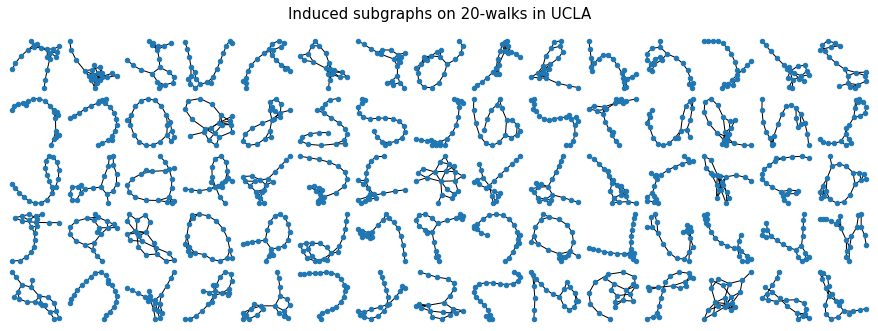

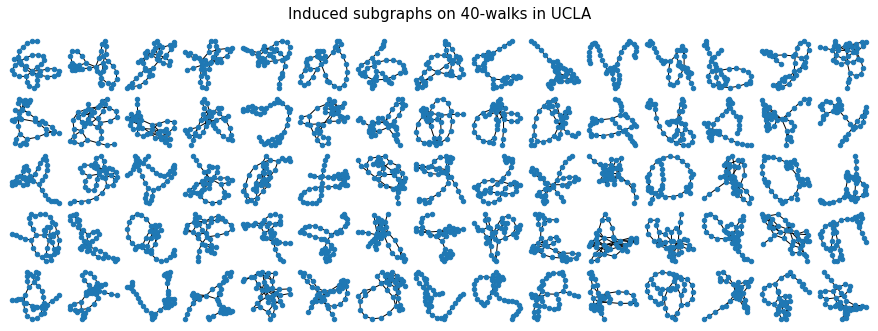

In [16]:
save_folder = 'SNMF_images/'

X1, embs1 = G.get_patches(k=k1, sample_size=900, skip_folded_hom=True)
X2, embs2 = G.get_patches(k=k2, sample_size=900, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k1, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "20_walk_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X1, embs1],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k2, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "40_walk_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X2, embs2],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [17]:
def generate_nxGraphList(X):
    
    graph_list = []
    k = int(np.sqrt(X.shape[0]))
    for i in range(X.shape[1]):
        adj_mat = X.T[i].reshape(k,k)
        G = nx.from_numpy_matrix(adj_mat)
        graph_list.append(G)
    
    return graph_list

graph_list1 = generate_nxGraphList(X1)
graph_list2 = generate_nxGraphList(X2)

In [30]:
def graphList2AdjMat(X, graph_list):
    
    num_nodes = int(np.sqrt(X.shape[0]))
    kappa = 10
    FCA_iter = 200

    df = pd.DataFrame()
    
    for G in graph_list:

        if nx.is_connected(G):

            adj_mat = nx.to_numpy_array(G)
            temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))

            initial_state = np.random.randint(0,kappa,size=num_nodes)

            states, label = FCA.FCA(G, initial_state, kappa, FCA_iter)

            width = FCA.width_compute(states[FCA_iter - 1], kappa)
            y = False
            if (width < floor(kappa / 2)):  # half circle concentration
                y = True

            sync = pd.DataFrame([y], columns=['Synchronized'])

            temp = pd.concat([temp, sync], axis=1)

            df = pd.concat([df, temp], ignore_index=True)


    return df


df1 = graphList2AdjMat(X1, graph_list1)


df2 = graphList2AdjMat(X2, graph_list2)

In [26]:
df1

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False
896,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,True
897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True


In [27]:
df2

,0,1,2,3,4,5,6,7,8,9,...,1591,1592,1593,1594,1595,1596,1597,1598,1599,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
896,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False


In [19]:
print(f"% of synchronized cases: {sum(df1['Synchronized'])/len(df1)}")
print(f"% of synchronized cases: {sum(df2['Synchronized'])/len(df2)}")

% of synchronized cases: 0.7188888888888889
% of synchronized cases: 0.2733333333333333


In [29]:
## Change FCA_iter to 500

print(f"% of synchronized cases: {sum(df11['Synchronized'])/len(df11)}")
print(f"% of synchronized cases: {sum(df22['Synchronized'])/len(df22)}")

% of synchronized cases: 0.7344444444444445
% of synchronized cases: 0.2877777777777778


In [20]:
X20 = df1.drop(['Synchronized'], axis=1).values
Y20 = df1['Synchronized'].values.reshape(-1,1)

X40 = df2.drop(['Synchronized'], axis=1).values
Y40 = df2['Synchronized'].values.reshape(-1,1)

X20_train, X20_test, Y20_train, Y20_test = train_test_split(X20, Y20, 
                                                            test_size=0.25)

X40_train, X40_test, Y40_train, Y40_test = train_test_split(X40, Y40, 
                                                            test_size=0.25)

In [21]:
# SDL_BCD_feature
data_scale=10
results_dict_list20 = []
iteration1 = 200
r = 16

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class20 = SDL_BCD(X = [X20_train.T/data_scale, Y20_train.T],
                                X_test = [X20_test.T/data_scale, Y20_test.T],
                                n_components = r,
                                xi = xi,
                                L1_reg = [0,0,0],
                                L2_reg = [0,0,0],
                                nonnegativity = [True,True,False],
                                full_dim = False)

        results_dict_new20 = SDL_BCD_class20.fit(option = "feature",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.11898953  0.76038944 -0.54379631  0.4166424  -0.57949496 -0.86314774
  -0.32055908 -0.59487194  0.279583   -0.94967039 -0.92473506  0.00747089
  -0.24699809  0.20933153 -0.36549479  0.08392101 -0.88573339]]


  2%|▋                                          | 3/200 [00:00<00:08, 24.26it/s]

--- Training --- [threshold, AUC] =  [0.624, 0.539]
--- Iteration 0: Training loss --- [Data, Label, Total] = [226.918441.3, 407.990714.3, 407.990714.3]


  5%|██                                        | 10/200 [00:00<00:06, 31.12it/s]


--- Training --- [threshold, AUC] =  [0.413, 0.598]
--- Iteration 10: Training loss --- [Data, Label, Total] = [269.222172.3, 535.079265.3, 535.079265.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.60929146  0.33413586  0.09610109  0.35791291  0.75502228 -0.08039494
   0.15973397 -0.05429151 -0.42875477 -0.87831508 -0.39442192  0.25849087
  -0.6997225   0.7613741  -0.37676175 -0.50175166  0.62145084]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.76, 0.464]
--- Iteration 0: Training loss --- [Data, Label, Total] = [232.068297.3, 389.294535.3, 389.294535.3]


  5%|██                                        | 10/200 [00:00<00:04, 40.78it/s]


--- Training --- [threshold, AUC] =  [0.937, 0.482]
--- Iteration 10: Training loss --- [Data, Label, Total] = [285.984657.3, 520.802219.3, 520.802219.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.04091957 -0.49643848  0.88802108  0.00398304 -0.26983479  0.16705508
   0.03801894 -0.27326374 -0.4697798   0.50388645  0.99744325 -0.27001766
   0.1128988  -0.49401633  0.81343133 -0.30586443 -0.10446017]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.846, 0.544]
--- Iteration 0: Training loss --- [Data, Label, Total] = [226.310326.3, 414.255619.3, 436.886652.3]


  5%|██                                        | 10/200 [00:00<00:04, 44.75it/s]

--- Training --- [threshold, AUC] =  [1.0, 0.629]
--- Iteration 10: Training loss --- [Data, Label, Total] = [254.826204.3, 1399.555383.3, 1425.038004.3]
Early stopping: training loss increased


!!! pred_type naive
initial loading beta [[ 0.41854049 -0.46676855  0.16095805 -0.32579592  0.00812908 -0.21407286
   0.1829686   0.52412672  0.86524501  0.96551148  0.7698267   0.21056996
   0.62931559  0.20919381  0.27235238  0.27711593 -0.05321518]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.762, 0.463]
--- Iteration 0: Training loss --- [Data, Label, Total] = [225.968050.3, 389.414135.3, 412.010940.3]


  5%|██                                        | 10/200 [00:00<00:04, 46.23it/s]

--- Training --- [threshold, AUC] =  [0.986, 0.527]
--- Iteration 10: Training loss --- [Data, Label, Total] = [232.173488.3, 759.311890.3, 782.529239.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[ 0.16452302 -0.93976429  0.4609761   0.38938036  0.18093488  0.24389577
   0.41960968  0.49890663 -0.83764693 -0.15150379 -0.32222833  0.37492621
  -0.84738074 -0.85192399 -0.55908412 -0.16329292 -0.80322678]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.832, 0.461]
--- Iteration 0: Training loss --- [Data, Label, Total] = [213.787863.3, 407.125436.3, 620.913299.3]


  5%|██                                        | 10/200 [00:00<00:04, 44.93it/s]

--- Training --- [threshold, AUC] =  [1.0, 0.497]
--- Iteration 10: Training loss --- [Data, Label, Total] = [142.402370.3, 1573.648583.3, 1716.050952.3]
Early stopping: training loss increased


!!! pred_type naive
initial loading beta [[-0.5356053   0.36174983  0.34034896  0.0633387   0.92640218  0.13022955
  -0.38667599 -0.58177852 -0.60560964 -0.85191486  0.80590923  0.23862411
   0.9826392   0.65229955  0.3466061   0.25514734 -0.68000721]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.462, 0.465]
--- Iteration 0: Training loss --- [Data, Label, Total] = [220.922142.3, 494.002766.3, 714.924908.3]


  5%|██                                        | 10/200 [00:00<00:04, 46.24it/s]

--- Training --- [threshold, AUC] =  [0.002, 0.536]
--- Iteration 10: Training loss --- [Data, Label, Total] = [143.570780.3, 2997.651303.3, 3141.222083.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[ 0.23816945  0.43483879 -0.07291821  0.16878962  0.5713282   0.65253184
  -0.64448958  0.86912308 -0.70314335 -0.91016325  0.21412261 -0.96204688
   0.22899767  0.22805308  0.27563832 -0.77534669  0.87482103]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.829, 0.466]
--- Iteration 0: Training loss --- [Data, Label, Total] = [184.956492.3, 405.986727.3, 1330.769189.3]


  5%|██                                        | 10/200 [00:00<00:03, 49.65it/s]

--- Training --- [threshold, AUC] =  [1.0, 0.592]
--- Iteration 10: Training loss --- [Data, Label, Total] = [106.807759.3, 1783.610638.3, 2317.649434.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[ 0.51646974 -0.03482508 -0.84726789  0.1083394  -0.52346068  0.60859695
   0.94684587 -0.28325073  0.00783853 -0.60305893 -0.57012728 -0.47819784
   0.9280192  -0.87932308  0.75784262 -0.07873629 -0.84972783]]


  2%|█                                          | 5/200 [00:00<00:03, 49.13it/s]

--- Training --- [threshold, AUC] =  [0.741, 0.466]
--- Iteration 0: Training loss --- [Data, Label, Total] = [194.112901.3, 388.396468.3, 1358.960972.3]


  8%|███▌                                      | 17/200 [00:00<00:03, 50.34it/s]

--- Training --- [threshold, AUC] =  [0.386, 0.591]
--- Iteration 10: Training loss --- [Data, Label, Total] = [119.005098.3, 560.612993.3, 1155.638485.3]
--- Training --- [threshold, AUC] =  [0.618, 0.594]
--- Iteration 20: Training loss --- [Data, Label, Total] = [48.640892.3, 409.878275.3, 653.082735.3]


 20%|████████▌                                 | 41/200 [00:00<00:03, 52.07it/s]

--- Training --- [threshold, AUC] =  [0.656, 0.583]
--- Iteration 30: Training loss --- [Data, Label, Total] = [17.384028.3, 398.952647.3, 485.872788.3]
--- Training --- [threshold, AUC] =  [0.728, 0.624]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.168702.3, 388.536463.3, 389.379973.3]


 30%|████████████▍                             | 59/200 [00:01<00:02, 54.39it/s]

--- Training --- [threshold, AUC] =  [0.764, 0.656]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.055197.3, 389.599388.3, 389.875373.3]
--- Training --- [threshold, AUC] =  [0.792, 0.679]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.045686.3, 394.043212.3, 394.271640.3]


 38%|████████████████▏                         | 77/200 [00:01<00:02, 55.21it/s]

--- Training --- [threshold, AUC] =  [0.815, 0.691]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.037022.3, 400.540129.3, 400.725242.3]
--- Training --- [threshold, AUC] =  [0.829, 0.693]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.036396.3, 405.972244.3, 406.154225.3]


 50%|████████████████████▋                    | 101/200 [00:01<00:01, 55.45it/s]

--- Training --- [threshold, AUC] =  [0.842, 0.696]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.036309.3, 412.321356.3, 412.502901.3]
--- Training --- [threshold, AUC] =  [0.854, 0.697]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.036264.3, 418.905997.3, 419.087317.3]


 60%|████████████████████████▍                | 119/200 [00:02<00:01, 56.35it/s]

--- Training --- [threshold, AUC] =  [0.862, 0.698]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.036226.3, 424.503741.3, 424.684869.3]
--- Training --- [threshold, AUC] =  [0.87, 0.699]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.036181.3, 430.731945.3, 430.912848.3]


 68%|████████████████████████████             | 137/200 [00:02<00:01, 56.40it/s]

--- Training --- [threshold, AUC] =  [0.878, 0.7]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.036142.3, 437.096488.3, 437.277201.3]
--- Training --- [threshold, AUC] =  [0.884, 0.701]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.036109.3, 442.808451.3, 442.988994.3]


 80%|█████████████████████████████████        | 161/200 [00:02<00:00, 54.73it/s]

--- Training --- [threshold, AUC] =  [0.89, 0.702]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.036072.3, 448.683815.3, 448.864176.3]
--- Training --- [threshold, AUC] =  [0.896, 0.703]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.036032.3, 455.262085.3, 455.442242.3]


 90%|████████████████████████████████████▋    | 179/200 [00:03<00:00, 56.69it/s]

--- Training --- [threshold, AUC] =  [0.901, 0.703]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.035995.3, 461.079164.3, 461.259139.3]
--- Training --- [threshold, AUC] =  [0.905, 0.704]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.035960.3, 466.786791.3, 466.966590.3]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 54.97it/s]

--- Training --- [threshold, AUC] =  [0.909, 0.704]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.035926.3, 471.936464.3, 472.116092.3]
!!! pred_type naive


initial loading beta [[-0.65889665  0.58764178  0.06970641 -0.68691059 -0.05247251  0.0140071
   0.46026192  0.88656214 -0.93785739  0.7330578  -0.91205352  0.04016045
   0.81555454 -0.88312774 -0.32989081  0.80332883  0.18808692]]


  3%|█▎                                         | 6/200 [00:00<00:03, 54.15it/s]

--- Training --- [threshold, AUC] =  [0.876, 0.537]
--- Iteration 0: Training loss --- [Data, Label, Total] = [197.097655.3, 435.073005.3, 2406.049556.3]


  5%|██                                        | 10/200 [00:00<00:03, 49.76it/s]

--- Training --- [threshold, AUC] =  [1.0, 0.465]
--- Iteration 10: Training loss --- [Data, Label, Total] = [120.584257.3, 1635.090234.3, 2840.932802.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[ 0.33226242 -0.04619272 -0.54402998  0.67882988 -0.1615829  -0.57852
   0.90562852 -0.71190984  0.99462273  0.85633187 -0.73866735  0.67458479
   0.87268722  0.09853619 -0.82099677 -0.44610974 -0.18681802]]


  3%|█▎                                         | 6/200 [00:00<00:03, 52.46it/s]

--- Training --- [threshold, AUC] =  [0.817, 0.464]
--- Iteration 0: Training loss --- [Data, Label, Total] = [195.251555.3, 401.103348.3, 2353.618896.3]
--- Training --- [threshold, AUC] =  [0.995, 0.5]
--- Iteration 10: Training loss --- [Data, Label, Total] = [98.332658.3, 933.895257.3, 1917.221837.3]


  9%|███▊                                      | 18/200 [00:00<00:03, 52.23it/s]

--- Training --- [threshold, AUC] =  [0.978, 0.52]
--- Iteration 20: Training loss --- [Data, Label, Total] = [54.749582.3, 688.510913.3, 1236.006734.3]


 15%|██████▎                                   | 30/200 [00:00<00:03, 52.84it/s]

--- Training --- [threshold, AUC] =  [0.975, 0.666]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.147370.3, 665.905796.3, 667.379501.3]


 18%|███████▌                                  | 36/200 [00:00<00:03, 52.51it/s]

--- Training --- [threshold, AUC] =  [0.976, 0.705]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.036086.3, 675.553590.3, 675.914451.3]


 24%|██████████                                | 48/200 [00:00<00:02, 53.77it/s]

--- Training --- [threshold, AUC] =  [0.978, 0.701]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.034762.3, 685.878416.3, 686.226037.3]


 30%|████████████▌                             | 60/200 [00:01<00:02, 55.13it/s]

--- Training --- [threshold, AUC] =  [0.979, 0.701]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.034378.3, 695.597843.3, 695.941623.3]


 36%|███████████████                           | 72/200 [00:01<00:02, 55.57it/s]

--- Training --- [threshold, AUC] =  [0.98, 0.701]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.034285.3, 704.678496.3, 705.021344.3]


 39%|████████████████▍                         | 78/200 [00:01<00:02, 56.03it/s]

--- Training --- [threshold, AUC] =  [0.981, 0.702]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.034250.3, 713.059758.3, 713.402260.3]


 46%|███████████████████                       | 91/200 [00:01<00:01, 57.43it/s]

--- Training --- [threshold, AUC] =  [0.982, 0.703]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.034230.3, 720.416828.3, 720.759125.3]


 48%|████████████████████▎                     | 97/200 [00:01<00:01, 57.68it/s]

--- Training --- [threshold, AUC] =  [0.983, 0.704]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.034214.3, 726.099976.3, 726.442120.3]


 55%|██████████████████████▌                  | 110/200 [00:01<00:01, 58.70it/s]

--- Training --- [threshold, AUC] =  [0.983, 0.704]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.034202.3, 733.253575.3, 733.595592.3]


 61%|█████████████████████████                | 122/200 [00:02<00:01, 58.75it/s]

--- Training --- [threshold, AUC] =  [0.984, 0.705]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.034190.3, 739.914057.3, 740.255962.3]


 64%|██████████████████████████▏              | 128/200 [00:02<00:01, 58.81it/s]

--- Training --- [threshold, AUC] =  [0.984, 0.705]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.034181.3, 744.828690.3, 745.170504.3]


 70%|████████████████████████████▉            | 141/200 [00:02<00:01, 58.11it/s]

--- Training --- [threshold, AUC] =  [0.985, 0.706]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.034173.3, 749.513782.3, 749.855516.3]


 74%|██████████████████████████████▏          | 147/200 [00:02<00:00, 58.44it/s]

--- Training --- [threshold, AUC] =  [0.985, 0.707]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.034166.3, 753.717970.3, 754.059633.3]


 80%|████████████████████████████████▌        | 159/200 [00:02<00:00, 58.59it/s]

--- Training --- [threshold, AUC] =  [0.986, 0.708]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.034159.3, 757.492254.3, 757.833848.3]


 86%|███████████████████████████████████      | 171/200 [00:03<00:00, 58.15it/s]

--- Training --- [threshold, AUC] =  [0.986, 0.708]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.034154.3, 761.257930.3, 761.599469.3]


 88%|████████████████████████████████████▎    | 177/200 [00:03<00:00, 58.64it/s]

--- Training --- [threshold, AUC] =  [0.986, 0.709]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.034149.3, 764.386787.3, 764.728277.3]


 95%|██████████████████████████████████████▉  | 190/200 [00:03<00:00, 59.38it/s]

--- Training --- [threshold, AUC] =  [0.986, 0.709]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.034145.3, 767.603991.3, 767.945438.3]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 56.69it/s]


!!! pred_type naive


In [22]:
results_dict_new20

{'xi': 10,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 16,
 'loading': [array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 2.68841217e-35],
         [7.86788190e-04, 8.49193198e-04, 4.07472148e-04, ...,
          2.01155306e-04, 5.34636706e-04, 1.55903878e-01],
         [0.00000000e+00, 0.00000000e+00, 4.63384100e-04, ...,
          0.00000000e+00, 1.26052395e-04, 8.80770355e-03],
         ...,
         [0.00000000e+00, 0.00000000e+00, 2.06753889e-04, ...,
          3.00767486e-05, 0.00000000e+00, 4.03198968e-02],
         [7.86788190e-04, 8.49193198e-04, 4.07472148e-04, ...,
          2.01155306e-04, 5.34636706e-04, 1.55903878e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 2.61701014e-35]]),
  array([[1.03429167e+00, 6.65234982e-05, 7.35866808e-05, 3.39077421e-05,
          2.50166287e-05, 4.44239300e-05, 2.68430247

In [23]:
W = results_dict_new20['loading'][0]
coeff = results_dict_new20['loading'][1][0]
H = results_dict_new20['code']

print('Accuracy: {}'.format(results_dict_new20['Accuracy']))
print('Training RRE: {}'.format(results_dict_new20['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new20['Relative_reconstruction_loss (test)']))

Accuracy: 0.4533333333333333
Training RRE: 0.24254623135893963
Testing RRE: 0.5195647677592194


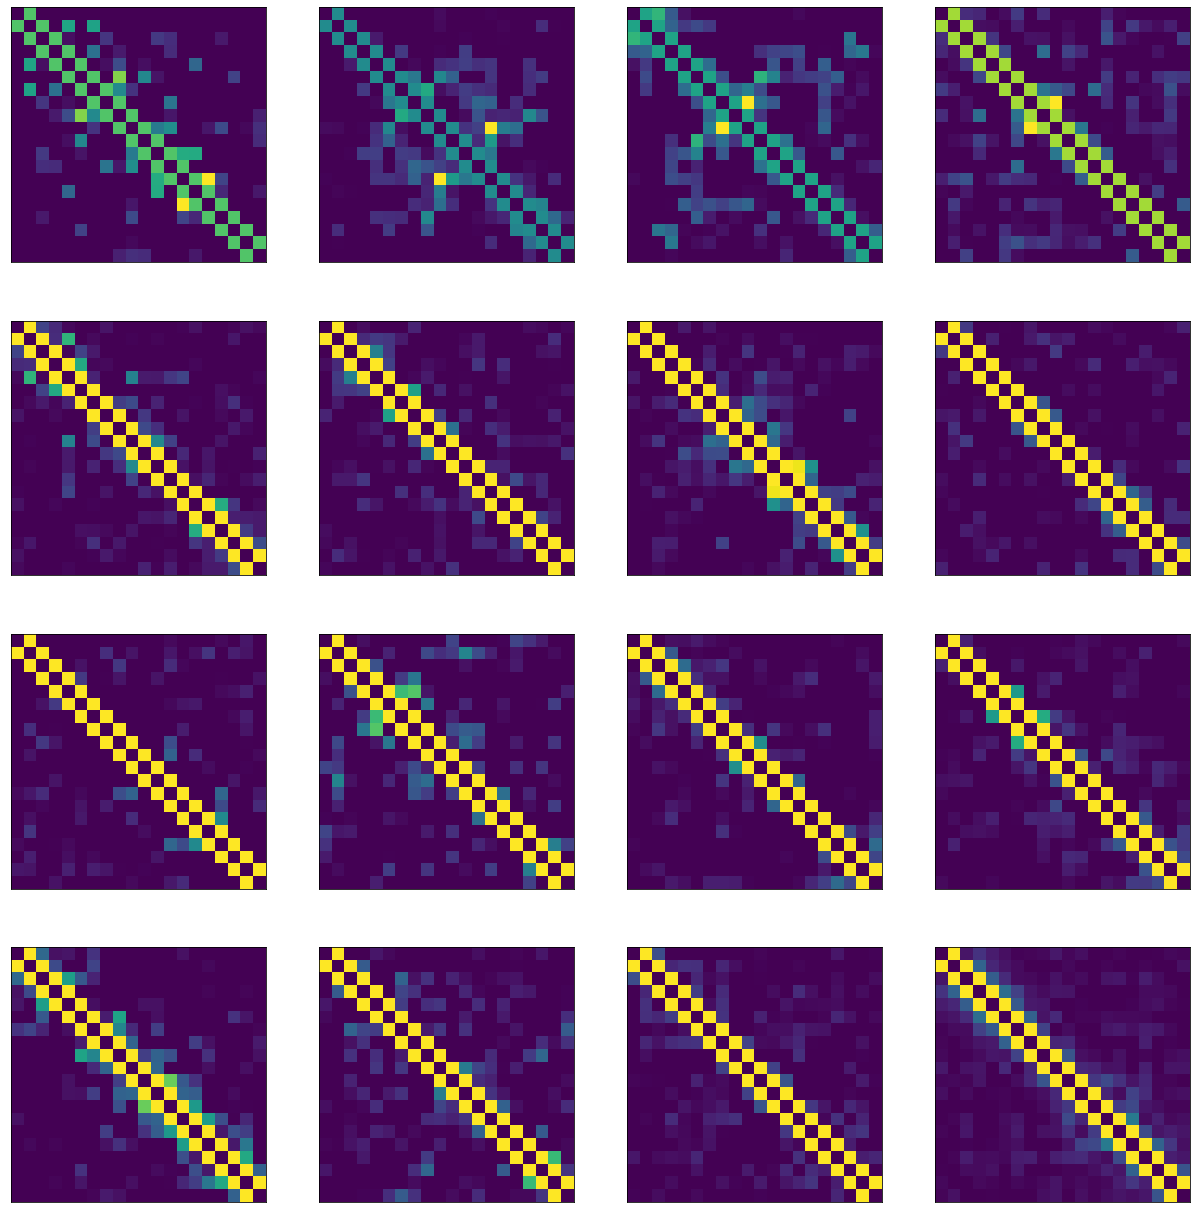

In [24]:
display_dictionary(W = W, figsize=[20,20])

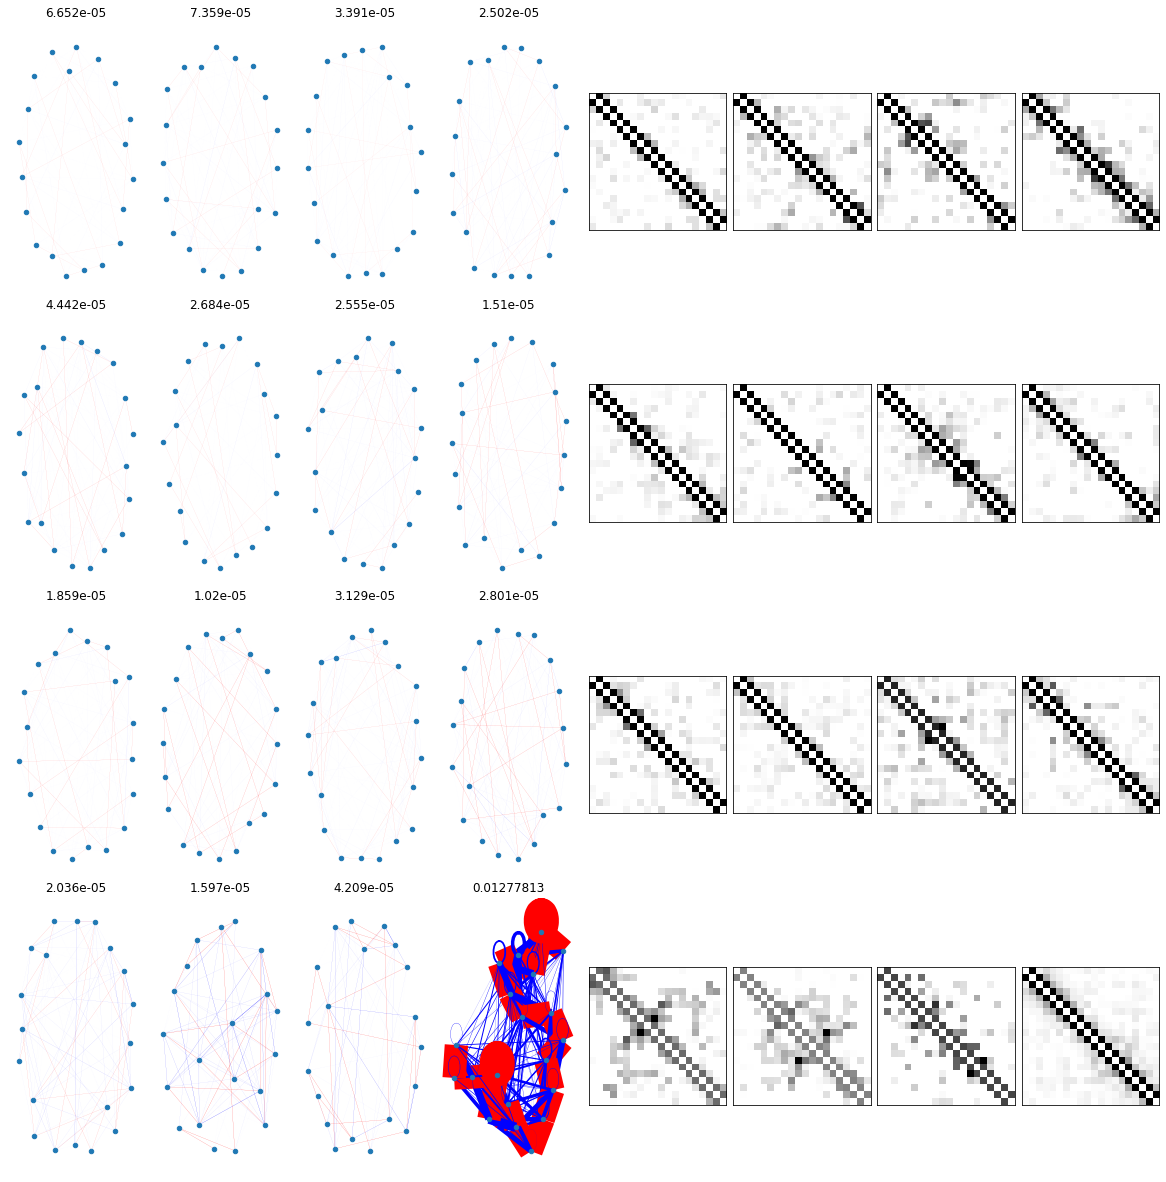

In [25]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 150, 
                       fig_size = [20,20], 
                       show_importance = True)

In [40]:
# SDL_BCD_filter
data_scale=10
results_dict_list20filter = []
iteration1 = 200
r = 16

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class20filter = SDL_BCD(X = [X20_train.T/data_scale, Y20_train.T],
                                X_test = [X20_test.T/data_scale, Y20_test.T],
                                n_components = r,
                                xi = xi,
                                L1_reg = [0,0,0],
                                L2_reg = [0,0,0],
                                nonnegativity = [True,True,False],
                                full_dim = False)

        results_dict_new20filter = SDL_BCD_class20filter.fit(option = "filter",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.07338688  0.58059389  0.15913039  0.44999435  0.81032177  0.32819395
   0.04708373  0.73054038  0.13048617  0.78287933 -0.3542248  -0.42453753
   0.86142797  0.78008483  0.67941635  0.80610279 -0.09350166]]


  3%|█▎                                         | 6/200 [00:00<00:03, 54.16it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.469]
--- Iteration 0: Training loss --- [Data, Label, Total] = [214.611606.3, 388.373722.3, 388.373722.3]
--- Training --- [threshold, AUC] =  [0.738, 0.47]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.394151.3, 388.373722.3, 388.373722.3]


 14%|██████                                    | 29/200 [00:00<00:02, 71.60it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.47]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.141725.3, 388.373721.3, 388.373721.3]
--- Training --- [threshold, AUC] =  [0.738, 0.472]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.125666.3, 388.373720.3, 388.373720.3]


 26%|██████████▋                               | 51/200 [00:00<00:02, 63.16it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.474]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.122248.3, 388.373718.3, 388.373718.3]
--- Training --- [threshold, AUC] =  [0.738, 0.476]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.120472.3, 388.373715.3, 388.373715.3]


 36%|███████████████                           | 72/200 [00:01<00:01, 65.57it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.478]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.119510.3, 388.373713.3, 388.373713.3]
--- Training --- [threshold, AUC] =  [0.738, 0.48]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.118997.3, 388.373710.3, 388.373710.3]


 48%|████████████████████▎                     | 97/200 [00:01<00:01, 75.24it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.482]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.118726.3, 388.373708.3, 388.373708.3]
--- Training --- [threshold, AUC] =  [0.738, 0.484]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.118584.3, 388.373705.3, 388.373705.3]


 56%|███████████████████████▏                 | 113/200 [00:01<00:01, 73.34it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.486]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.118502.3, 388.373703.3, 388.373703.3]
--- Training --- [threshold, AUC] =  [0.738, 0.487]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.118449.3, 388.373700.3, 388.373700.3]


 64%|██████████████████████████▍              | 129/200 [00:01<00:00, 72.94it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.489]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.118412.3, 388.373697.3, 388.373697.3]
--- Training --- [threshold, AUC] =  [0.738, 0.49]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.118384.3, 388.373695.3, 388.373695.3]


 77%|███████████████████████████████▌         | 154/200 [00:02<00:00, 76.71it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.492]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.118362.3, 388.373692.3, 388.373692.3]
--- Training --- [threshold, AUC] =  [0.738, 0.493]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.118343.3, 388.373689.3, 388.373689.3]


 85%|██████████████████████████████████▊      | 170/200 [00:02<00:00, 73.26it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.494]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.118328.3, 388.373687.3, 388.373687.3]
--- Training --- [threshold, AUC] =  [0.738, 0.496]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.118315.3, 388.373684.3, 388.373684.3]


 98%|███████████████████████████████████████▉ | 195/200 [00:02<00:00, 71.97it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.497]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.118304.3, 388.373681.3, 388.373681.3]
--- Training --- [threshold, AUC] =  [0.738, 0.499]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.118295.3, 388.373679.3, 388.373679.3]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 70.51it/s]


!!! pred_type filter
initial loading beta [[ 0.60721983  0.28118473  0.87210451 -0.63802565  0.81959988 -0.32817341
  -0.3585863  -0.31945066  0.33007144  0.87422643 -0.75461723 -0.6156337
  -0.87687198  0.79195138 -0.48012976  0.27247959 -0.90297105]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.471]
--- Iteration 0: Training loss --- [Data, Label, Total] = [210.191784.3, 388.373721.3, 388.373721.3]


  7%|██▉                                       | 14/200 [00:00<00:02, 65.88it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.471]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.430167.3, 388.373721.3, 388.373721.3]


 10%|████▍                                     | 21/200 [00:00<00:02, 66.24it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.472]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.146501.3, 388.373720.3, 388.373720.3]


 14%|██████                                    | 29/200 [00:00<00:02, 68.96it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.473]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.127330.3, 388.373718.3, 388.373718.3]


 22%|█████████▍                                | 45/200 [00:00<00:02, 70.82it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.475]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.123925.3, 388.373716.3, 388.373716.3]


 26%|███████████▏                              | 53/200 [00:00<00:02, 71.41it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.477]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.122231.3, 388.373714.3, 388.373714.3]


 30%|████████████▊                             | 61/200 [00:00<00:01, 72.24it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.479]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.121294.3, 388.373712.3, 388.373712.3]


 34%|██████████████▍                           | 69/200 [00:00<00:01, 74.34it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.48]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.120769.3, 388.373709.3, 388.373709.3]


 42%|█████████████████▊                        | 85/200 [00:01<00:01, 73.98it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.482]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.120473.3, 388.373707.3, 388.373707.3]


 46%|███████████████████▌                      | 93/200 [00:01<00:01, 74.37it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.483]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.120308.3, 388.373704.3, 388.373704.3]


 50%|████████████████████▋                    | 101/200 [00:01<00:01, 74.44it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.485]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.120213.3, 388.373702.3, 388.373702.3]


 55%|██████████████████████▎                  | 109/200 [00:01<00:01, 74.74it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.486]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.120154.3, 388.373699.3, 388.373699.3]


 62%|█████████████████████████▋               | 125/200 [00:01<00:01, 74.45it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.488]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.120115.3, 388.373697.3, 388.373697.3]


 66%|███████████████████████████▎             | 133/200 [00:01<00:00, 74.29it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.49]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.120086.3, 388.373694.3, 388.373694.3]


 70%|████████████████████████████▉            | 141/200 [00:01<00:00, 71.64it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.120065.3, 388.373691.3, 388.373691.3]


 74%|██████████████████████████████▌          | 149/200 [00:02<00:00, 72.17it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.492]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.120047.3, 388.373689.3, 388.373689.3]


 82%|█████████████████████████████████▊       | 165/200 [00:02<00:00, 72.33it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.494]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.120033.3, 388.373686.3, 388.373686.3]


 86%|███████████████████████████████████▍     | 173/200 [00:02<00:00, 72.22it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.496]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.120022.3, 388.373683.3, 388.373683.3]


 90%|█████████████████████████████████████    | 181/200 [00:02<00:00, 72.68it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.497]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.120013.3, 388.373681.3, 388.373681.3]


 95%|██████████████████████████████████████▉  | 190/200 [00:02<00:00, 75.38it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.498]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.120006.3, 388.373678.3, 388.373678.3]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 71.79it/s]


!!! pred_type filter
initial loading beta [[ 0.25191039 -0.79129064  0.53538819  0.50880806 -0.46559814 -0.11498871
   0.98138366  0.58945409  0.12591273  0.18675907 -0.40718898  0.99413401
  -0.62933118  0.0707049  -0.58401065  0.8395421  -0.78638366]]


  3%|█▎                                         | 6/200 [00:00<00:03, 57.51it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.468]
--- Iteration 0: Training loss --- [Data, Label, Total] = [221.765637.3, 388.373723.3, 410.550286.3]
--- Training --- [threshold, AUC] =  [0.738, 0.468]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.438699.3, 388.373723.3, 388.417593.3]


 18%|███████▌                                  | 36/200 [00:00<00:02, 68.01it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.47]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.133270.3, 388.373721.3, 388.387048.3]
--- Training --- [threshold, AUC] =  [0.738, 0.472]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.083128.3, 388.373719.3, 388.382032.3]


 26%|███████████▏                              | 53/200 [00:00<00:01, 75.15it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.474]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.052348.3, 388.373717.3, 388.378952.3]
--- Training --- [threshold, AUC] =  [0.738, 0.475]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.039957.3, 388.373716.3, 388.377711.3]


 35%|██████████████▋                           | 70/200 [00:00<00:01, 77.45it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.477]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.036382.3, 388.373715.3, 388.377353.3]
--- Training --- [threshold, AUC] =  [0.738, 0.477]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.035175.3, 388.373714.3, 388.377231.3]


 48%|████████████████████▎                     | 97/200 [00:01<00:01, 81.38it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.478]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.034624.3, 388.373713.3, 388.377175.3]
--- Training --- [threshold, AUC] =  [0.738, 0.479]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.034315.3, 388.373712.3, 388.377144.3]


 57%|███████████████████████▌                 | 115/200 [00:01<00:01, 80.43it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.479]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.034119.3, 388.373711.3, 388.377123.3]
--- Training --- [threshold, AUC] =  [0.738, 0.48]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.033986.3, 388.373711.3, 388.377109.3]


 66%|███████████████████████████▎             | 133/200 [00:01<00:00, 76.47it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.481]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.033891.3, 388.373710.3, 388.377099.3]
--- Training --- [threshold, AUC] =  [0.738, 0.481]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.033820.3, 388.373709.3, 388.377091.3]


 74%|██████████████████████████████▌          | 149/200 [00:02<00:00, 70.42it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.482]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.033764.3, 388.373708.3, 388.377085.3]
--- Training --- [threshold, AUC] =  [0.738, 0.482]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.033719.3, 388.373707.3, 388.377079.3]


 87%|███████████████████████████████████▋     | 174/200 [00:02<00:00, 74.93it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.483]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.033682.3, 388.373707.3, 388.377075.3]
--- Training --- [threshold, AUC] =  [0.738, 0.483]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.033651.3, 388.373706.3, 388.377071.3]


 95%|██████████████████████████████████████▉  | 190/200 [00:02<00:00, 72.99it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.484]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.033624.3, 388.373705.3, 388.377067.3]
--- Training --- [threshold, AUC] =  [0.738, 0.485]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.033600.3, 388.373704.3, 388.377064.3]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 73.52it/s]


!!! pred_type filter
initial loading beta [[-0.05122614  0.04493871 -0.80884857 -0.89735026  0.46549401  0.22972609
   0.0956958  -0.51440646 -0.95771061 -0.0334016   0.81114198  0.41400705
  -0.23013726 -0.45194233  0.25070398  0.79211605  0.68744519]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.471]
--- Iteration 0: Training loss --- [Data, Label, Total] = [226.401759.3, 388.373721.3, 411.013897.3]


  7%|██▉                                       | 14/200 [00:00<00:02, 65.00it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.474]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.460090.3, 388.373719.3, 388.419728.3]


 11%|████▌                                     | 22/200 [00:00<00:02, 70.10it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.477]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.135456.3, 388.373716.3, 388.387262.3]


 15%|██████▎                                   | 30/200 [00:00<00:02, 71.38it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.48]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.087739.3, 388.373713.3, 388.382487.3]


 19%|███████▉                                  | 38/200 [00:00<00:02, 70.43it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.482]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.057468.3, 388.373710.3, 388.379457.3]


 27%|███████████▎                              | 54/200 [00:00<00:02, 72.93it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.484]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.043404.3, 388.373707.3, 388.378048.3]


 31%|█████████████                             | 62/200 [00:00<00:01, 73.16it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.485]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.038547.3, 388.373706.3, 388.377560.3]


 35%|██████████████▋                           | 70/200 [00:00<00:01, 72.60it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.486]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.036600.3, 388.373704.3, 388.377364.3]


 39%|████████████████▍                         | 78/200 [00:01<00:01, 71.28it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.487]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.035598.3, 388.373703.3, 388.377263.3]


 48%|████████████████████▏                     | 96/200 [00:01<00:01, 76.95it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.488]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.034997.3, 388.373701.3, 388.377201.3]


 52%|█████████████████████▌                   | 105/200 [00:01<00:01, 78.44it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.489]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.034602.3, 388.373700.3, 388.377160.3]


 56%|███████████████████████▏                 | 113/200 [00:01<00:01, 76.74it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.489]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.034324.3, 388.373698.3, 388.377131.3]


 60%|████████████████████████▊                | 121/200 [00:01<00:01, 75.12it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.49]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.034117.3, 388.373697.3, 388.377109.3]


 64%|██████████████████████████▍              | 129/200 [00:01<00:00, 74.41it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.033956.3, 388.373696.3, 388.377091.3]


 73%|█████████████████████████████▉           | 146/200 [00:01<00:00, 77.48it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.492]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.033824.3, 388.373694.3, 388.377077.3]


 77%|███████████████████████████████▌         | 154/200 [00:02<00:00, 73.65it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.493]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.033712.3, 388.373693.3, 388.377064.3]


 81%|█████████████████████████████████▏       | 162/200 [00:02<00:00, 69.96it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.494]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.033614.3, 388.373692.3, 388.377053.3]


 85%|██████████████████████████████████▊      | 170/200 [00:02<00:00, 67.95it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.495]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.033524.3, 388.373690.3, 388.377043.3]


 89%|████████████████████████████████████▍    | 178/200 [00:02<00:00, 68.78it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.495]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.033439.3, 388.373689.3, 388.377033.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:02<00:00, 61.79it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.496]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.033357.3, 388.373688.3, 388.377024.3]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 70.80it/s]

!!! pred_type filter


initial loading beta [[-0.75763811  0.25490185 -0.19471668 -0.07923793  0.1540009  -0.29853965
  -0.45272124  0.11054197  0.73801787  0.18863717  0.56116522  0.35842803
  -0.85144324 -0.85431564  0.41439337 -0.03419839 -0.2495687 ]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.473]
--- Iteration 0: Training loss --- [Data, Label, Total] = [284.971432.3, 388.373722.3, 673.345154.3]


  4%|█▋                                         | 8/200 [00:00<00:02, 72.87it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.484]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.751598.3, 388.373718.3, 389.125316.3]


 12%|█████▎                                    | 25/200 [00:00<00:02, 78.51it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.485]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.150732.3, 388.373717.3, 388.524449.3]


 16%|██████▉                                   | 33/200 [00:00<00:02, 77.82it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.486]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.078451.3, 388.373717.3, 388.452168.3]


 20%|████████▌                                 | 41/200 [00:00<00:02, 76.80it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.486]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.057846.3, 388.373716.3, 388.431563.3]


 24%|██████████▎                               | 49/200 [00:00<00:01, 76.20it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.486]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.049049.3, 388.373716.3, 388.422766.3]


 32%|█████████████▋                            | 65/200 [00:00<00:01, 75.89it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.486]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.044314.3, 388.373716.3, 388.418030.3]


 36%|███████████████▎                          | 73/200 [00:00<00:01, 74.59it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.486]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.041386.3, 388.373716.3, 388.415102.3]


 41%|█████████████████▏                        | 82/200 [00:01<00:01, 77.50it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.487]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.039420.3, 388.373716.3, 388.413136.3]


 46%|███████████████████                       | 91/200 [00:01<00:01, 78.92it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.487]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.038034.3, 388.373716.3, 388.411750.3]


 50%|████████████████████▌                    | 100/200 [00:01<00:01, 80.07it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.487]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.037027.3, 388.373716.3, 388.410743.3]


 55%|██████████████████████▎                  | 109/200 [00:01<00:01, 78.54it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.487]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.036279.3, 388.373716.3, 388.409995.3]


 64%|██████████████████████████               | 127/200 [00:01<00:00, 80.23it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.487]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.035716.3, 388.373716.3, 388.409432.3]
--- Training --- [threshold, AUC] =  [0.738, 0.487]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.035287.3, 388.373716.3, 388.409003.3]


 72%|█████████████████████████████▌           | 144/200 [00:01<00:00, 74.75it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.487]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.034957.3, 388.373716.3, 388.408673.3]


 76%|███████████████████████████████▏         | 152/200 [00:01<00:00, 72.38it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.487]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.034698.3, 388.373716.3, 388.408414.3]


 80%|████████████████████████████████▊        | 160/200 [00:02<00:00, 70.37it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.487]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.034493.3, 388.373715.3, 388.408208.3]


 84%|██████████████████████████████████▍      | 168/200 [00:02<00:00, 70.00it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.487]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.034328.3, 388.373715.3, 388.408043.3]


 92%|█████████████████████████████████████▌   | 183/200 [00:02<00:00, 68.16it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.488]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.034193.3, 388.373715.3, 388.407908.3]


 96%|███████████████████████████████████████▏ | 191/200 [00:02<00:00, 68.94it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.488]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.034081.3, 388.373715.3, 388.407797.3]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 74.75it/s]

!!! pred_type filter


initial loading beta [[ 0.56356074  0.35212948  0.07718893 -0.12944478  0.0468418  -0.60220745
   0.65057344 -0.76922967  0.0136947  -0.5379423   0.11621366 -0.14238834
   0.45694777  0.37126698 -0.8063284  -0.61387296 -0.99769035]]


  4%|█▋                                         | 8/200 [00:00<00:02, 71.72it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.47]
--- Iteration 0: Training loss --- [Data, Label, Total] = [284.390664.3, 388.373723.3, 672.764387.3]
--- Training --- [threshold, AUC] =  [0.738, 0.473]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.507216.3, 388.373721.3, 388.880936.3]


 16%|██████▋                                   | 32/200 [00:00<00:02, 74.34it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.473]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.109639.3, 388.373720.3, 388.483360.3]
--- Training --- [threshold, AUC] =  [0.738, 0.473]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.063108.3, 388.373720.3, 388.436829.3]


 24%|██████████▎                               | 49/200 [00:00<00:01, 76.27it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.473]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.049971.3, 388.373720.3, 388.423691.3]
--- Training --- [threshold, AUC] =  [0.738, 0.473]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.044629.3, 388.373720.3, 388.418350.3]


 38%|███████████████▉                          | 76/200 [00:00<00:01, 79.72it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.473]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.041874.3, 388.373720.3, 388.415595.3]
--- Training --- [threshold, AUC] =  [0.738, 0.473]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.040194.3, 388.373720.3, 388.413915.3]


 46%|███████████████████▎                      | 92/200 [00:01<00:01, 76.37it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.473]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.039042.3, 388.373720.3, 388.412762.3]
--- Training --- [threshold, AUC] =  [0.738, 0.473]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.038182.3, 388.373720.3, 388.411902.3]


 58%|███████████████████████▊                 | 116/200 [00:01<00:01, 74.70it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.474]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.037503.3, 388.373720.3, 388.411223.3]
--- Training --- [threshold, AUC] =  [0.738, 0.474]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.036949.3, 388.373720.3, 388.410668.3]


 66%|███████████████████████████▎             | 133/200 [00:01<00:00, 78.73it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.474]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.036485.3, 388.373720.3, 388.410204.3]
--- Training --- [threshold, AUC] =  [0.738, 0.474]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.036089.3, 388.373720.3, 388.409809.3]


 74%|██████████████████████████████▌          | 149/200 [00:01<00:00, 69.26it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.474]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.035750.3, 388.373720.3, 388.409470.3]
--- Training --- [threshold, AUC] =  [0.738, 0.474]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.035456.3, 388.373720.3, 388.409176.3]


 88%|███████████████████████████████████▉     | 175/200 [00:02<00:00, 78.69it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.474]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.035201.3, 388.373720.3, 388.408921.3]
--- Training --- [threshold, AUC] =  [0.738, 0.474]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.034980.3, 388.373720.3, 388.408699.3]


 96%|███████████████████████████████████████▌ | 193/200 [00:02<00:00, 81.68it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.474]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.034787.3, 388.373720.3, 388.408507.3]
--- Training --- [threshold, AUC] =  [0.738, 0.474]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.034620.3, 388.373720.3, 388.408340.3]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 76.85it/s]


!!! pred_type filter
initial loading beta [[ 0.66619171 -0.94371462 -0.84746393 -0.35325616 -0.95023298  0.40462981
   0.48962073 -0.13157268 -0.42623628  0.71117163 -0.1642802  -0.02156544
   0.63717423  0.56296693  0.67311914 -0.49762271 -0.35685777]]


  4%|█▋                                         | 8/200 [00:00<00:02, 73.26it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.468]
--- Iteration 0: Training loss --- [Data, Label, Total] = [255.344904.3, 388.373725.3, 1665.098247.3]
--- Training --- [threshold, AUC] =  [0.738, 0.49]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.593450.3, 388.373719.3, 391.340970.3]


 16%|██████▋                                   | 32/200 [00:00<00:02, 74.20it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.49]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.083845.3, 388.373719.3, 388.792946.3]
--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.049587.3, 388.373719.3, 388.621653.3]


 28%|███████████▊                              | 56/200 [00:00<00:01, 73.55it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.041162.3, 388.373719.3, 388.579527.3]
--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.038468.3, 388.373719.3, 388.566058.3]


 36%|███████████████▎                          | 73/200 [00:00<00:01, 78.03it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.037494.3, 388.373719.3, 388.561188.3]
--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.037106.3, 388.373719.3, 388.559251.3]


 44%|██████████████████▋                       | 89/200 [00:01<00:01, 67.34it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.036938.3, 388.373719.3, 388.558411.3]
--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.036859.3, 388.373719.3, 388.558014.3]


 55%|██████████████████████▌                  | 110/200 [00:01<00:01, 65.21it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.036816.3, 388.373719.3, 388.557798.3]
--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.036786.3, 388.373719.3, 388.557651.3]


 66%|███████████████████████████              | 132/200 [00:01<00:01, 66.37it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.036763.3, 388.373719.3, 388.557533.3]
--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.036741.3, 388.373719.3, 388.557425.3]


 74%|██████████████████████████████▏          | 147/200 [00:02<00:00, 66.68it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.036721.3, 388.373719.3, 388.557322.3]
--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.036700.3, 388.373719.3, 388.557221.3]


 86%|███████████████████████████████████      | 171/200 [00:02<00:00, 72.39it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.036681.3, 388.373719.3, 388.557122.3]
--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.036661.3, 388.373719.3, 388.557023.3]


 97%|███████████████████████████████████████▊ | 194/200 [00:02<00:00, 67.84it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.036641.3, 388.373719.3, 388.556926.3]
--- Training --- [threshold, AUC] =  [0.738, 0.491]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.036622.3, 388.373719.3, 388.556828.3]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 69.07it/s]


!!! pred_type filter
initial loading beta [[ 0.74034135 -0.45968748  0.2453598  -0.13617498  0.61202667 -0.84622487
  -0.0950284  -0.90523785 -0.09439745 -0.87649024 -0.31535672 -0.5018337
   0.43971671  0.90904528 -0.78740398 -0.89509897 -0.22890083]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.471]
--- Iteration 0: Training loss --- [Data, Label, Total] = [254.877071.3, 388.373724.3, 1662.759077.3]


  4%|█▉                                         | 9/200 [00:00<00:02, 81.17it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.385505.3, 388.373728.3, 390.301254.3]


 13%|█████▍                                    | 26/200 [00:00<00:02, 75.81it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.045985.3, 388.373728.3, 388.603652.3]


 17%|███████▏                                  | 34/200 [00:00<00:02, 72.05it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.037294.3, 388.373728.3, 388.560197.3]


 21%|████████▊                                 | 42/200 [00:00<00:02, 69.59it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.036538.3, 388.373728.3, 388.556417.3]


 24%|██████████▎                               | 49/200 [00:00<00:02, 69.51it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.036437.3, 388.373728.3, 388.555914.3]


 32%|█████████████▍                            | 64/200 [00:00<00:01, 70.09it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.036409.3, 388.373728.3, 388.555774.3]


 36%|███████████████                           | 72/200 [00:00<00:01, 72.83it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.036392.3, 388.373728.3, 388.555687.3]


 40%|█████████████████                         | 81/200 [00:01<00:01, 75.98it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.036376.3, 388.373728.3, 388.555609.3]


 45%|██████████████████▉                       | 90/200 [00:01<00:01, 78.25it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.036361.3, 388.373728.3, 388.555534.3]


 54%|█████████████████████▉                   | 107/200 [00:01<00:01, 78.59it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.036346.3, 388.373728.3, 388.555458.3]


 57%|███████████████████████▌                 | 115/200 [00:01<00:01, 77.74it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.036331.3, 388.373728.3, 388.555384.3]


 62%|█████████████████████████▏               | 123/200 [00:01<00:01, 76.52it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.036316.3, 388.373728.3, 388.555310.3]


 66%|███████████████████████████              | 132/200 [00:01<00:00, 79.26it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.036302.3, 388.373728.3, 388.555236.3]


 70%|████████████████████████████▉            | 141/200 [00:01<00:00, 79.99it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.036287.3, 388.373728.3, 388.555162.3]


 75%|██████████████████████████████▊          | 150/200 [00:01<00:00, 78.83it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.036272.3, 388.373728.3, 388.555089.3]


 83%|██████████████████████████████████       | 166/200 [00:02<00:00, 75.81it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.036258.3, 388.373728.3, 388.555017.3]


 87%|███████████████████████████████████▋     | 174/200 [00:02<00:00, 75.86it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.036243.3, 388.373728.3, 388.554945.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:02<00:00, 73.19it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.036229.3, 388.373728.3, 388.554873.3]


 95%|██████████████████████████████████████▉  | 190/200 [00:02<00:00, 73.00it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.036215.3, 388.373728.3, 388.554802.3]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 74.95it/s]


!!! pred_type filter
initial loading beta [[ 0.86681031  0.51844729  0.79732718 -0.32291109  0.79998011  0.37972338
  -0.65579858  0.55426838 -0.42436704  0.83468693  0.67085599 -0.69209483
  -0.57931827  0.36100779 -0.20463727 -0.46337827 -0.31300701]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.427]
--- Iteration 0: Training loss --- [Data, Label, Total] = [100.909515.3, 388.373725.3, 1397.468879.3]


  4%|█▋                                         | 8/200 [00:00<00:02, 76.00it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.458]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.165309.3, 388.373725.3, 390.026815.3]


 12%|█████                                     | 24/200 [00:00<00:02, 78.40it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.136833.3, 388.373725.3, 389.742058.3]


 16%|██████▋                                   | 32/200 [00:00<00:02, 74.66it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.456]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.136747.3, 388.373725.3, 389.741198.3]


 20%|████████▍                                 | 40/200 [00:00<00:02, 75.32it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.457]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.136748.3, 388.373725.3, 389.741208.3]


 24%|██████████▎                               | 49/200 [00:00<00:01, 77.52it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.457]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.136747.3, 388.373725.3, 389.741194.3]


 28%|███████████▉                              | 57/200 [00:00<00:01, 72.28it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.457]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.136744.3, 388.373725.3, 389.741166.3]


 32%|█████████████▋                            | 65/200 [00:00<00:01, 68.42it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.457]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.136741.3, 388.373725.3, 389.741133.3]


 40%|████████████████▌                         | 79/200 [00:01<00:01, 61.88it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.458]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.136737.3, 388.373725.3, 389.741097.3]


 47%|███████████████████▋                      | 94/200 [00:01<00:01, 66.44it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.458]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.136733.3, 388.373725.3, 389.741060.3]


 51%|████████████████████▉                    | 102/200 [00:01<00:01, 68.34it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.459]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.136730.3, 388.373725.3, 389.741022.3]


 55%|██████████████████████▎                  | 109/200 [00:01<00:01, 68.00it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.459]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.136726.3, 388.373725.3, 389.740982.3]


 62%|█████████████████████████▏               | 123/200 [00:01<00:01, 64.39it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.46]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.136722.3, 388.373725.3, 389.740942.3]


 66%|██████████████████████████▊              | 131/200 [00:01<00:01, 65.37it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.46]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.136718.3, 388.373725.3, 389.740901.3]


 69%|████████████████████████████▎            | 138/200 [00:02<00:00, 63.95it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.461]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.136714.3, 388.373725.3, 389.740861.3]


 72%|█████████████████████████████▋           | 145/200 [00:02<00:00, 63.01it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.462]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.136710.3, 388.373725.3, 389.740821.3]


 80%|████████████████████████████████▊        | 160/200 [00:02<00:00, 62.68it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.463]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.136705.3, 388.373725.3, 389.740777.3]


 88%|████████████████████████████████████▎    | 177/200 [00:02<00:00, 71.24it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.463]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.136700.3, 388.373725.3, 389.740730.3]


 93%|██████████████████████████████████████▏  | 186/200 [00:02<00:00, 74.34it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.464]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.136696.3, 388.373725.3, 389.740683.3]


 97%|███████████████████████████████████████▊ | 194/200 [00:02<00:00, 70.92it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.464]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.136691.3, 388.373725.3, 389.740635.3]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 67.66it/s]


!!! pred_type filter
initial loading beta [[ 0.73866853 -0.48502646 -0.97215403 -0.09277428  0.52232841 -0.95606118
  -0.93275508  0.95345677 -0.52822537 -0.44453734  0.20354935 -0.41669942
  -0.36599422  0.95516531 -0.7438599  -0.49342973  0.12870788]]


  4%|█▌                                         | 7/200 [00:00<00:03, 61.86it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.539]
--- Iteration 0: Training loss --- [Data, Label, Total] = [122.721051.3, 388.373725.3, 1615.584240.3]
--- Training --- [threshold, AUC] =  [0.738, 0.526]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.358426.3, 388.373725.3, 391.957983.3]


 12%|█████                                     | 24/200 [00:00<00:02, 75.18it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.521]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.176086.3, 388.373725.3, 390.134583.3]


 16%|██████▉                                   | 33/200 [00:00<00:02, 77.92it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.516]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.148519.3, 388.373725.3, 389.858914.3]


 20%|████████▌                                 | 41/200 [00:00<00:02, 78.43it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.515]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.141611.3, 388.373725.3, 389.789836.3]


 25%|██████████▌                               | 50/200 [00:00<00:01, 81.08it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.513]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.139744.3, 388.373725.3, 389.771164.3]


 30%|████████████▍                             | 59/200 [00:00<00:01, 77.06it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.512]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.139282.3, 388.373725.3, 389.766544.3]


 38%|███████████████▊                          | 75/200 [00:00<00:01, 76.07it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.513]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.139206.3, 388.373725.3, 389.765786.3]


 42%|█████████████████▍                        | 83/200 [00:01<00:01, 73.93it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.512]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.139221.3, 388.373725.3, 389.765934.3]


 46%|███████████████████                       | 91/200 [00:01<00:01, 74.76it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.512]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.139244.3, 388.373725.3, 389.766170.3]


 50%|████████████████████▊                     | 99/200 [00:01<00:01, 75.59it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.512]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.139258.3, 388.373725.3, 389.766306.3]


 57%|███████████████████████▌                 | 115/200 [00:01<00:01, 75.47it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.513]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.139261.3, 388.373725.3, 389.766338.3]


 62%|█████████████████████████▏               | 123/200 [00:01<00:01, 74.61it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.513]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.139259.3, 388.373725.3, 389.766313.3]


 66%|██████████████████████████▊              | 131/200 [00:01<00:00, 74.17it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.513]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.139254.3, 388.373725.3, 389.766262.3]


 70%|████████████████████████████▍            | 139/200 [00:01<00:00, 75.35it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.512]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.139247.3, 388.373725.3, 389.766199.3]


 78%|████████████████████████████████▏        | 157/200 [00:02<00:00, 78.98it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.513]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.139240.3, 388.373725.3, 389.766123.3]


 82%|█████████████████████████████████▊       | 165/200 [00:02<00:00, 78.57it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.512]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.139232.3, 388.373725.3, 389.766041.3]


 86%|███████████████████████████████████▍     | 173/200 [00:02<00:00, 78.51it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.512]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.139223.3, 388.373725.3, 389.765956.3]


 90%|█████████████████████████████████████    | 181/200 [00:02<00:00, 71.93it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.512]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.139215.3, 388.373725.3, 389.765871.3]


 94%|██████████████████████████████████████▋  | 189/200 [00:02<00:00, 72.15it/s]

--- Training --- [threshold, AUC] =  [0.738, 0.511]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.139206.3, 388.373725.3, 389.765788.3]


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 75.00it/s]


!!! pred_type filter


In [41]:
W = results_dict_new20filter['loading'][0]
coeff = results_dict_new20filter['loading'][1][0]
H = results_dict_new20filter['code']

print('Accuracy: {}'.format(results_dict_new20filter['Accuracy']))
print('Training RRE: {}'.format(results_dict_new20filter['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new20filter['Relative_reconstruction_loss (test)']))

Accuracy: 0.5155555555555555
Training RRE: 0.9888493768318689
Testing RRE: 0.6286217921703467


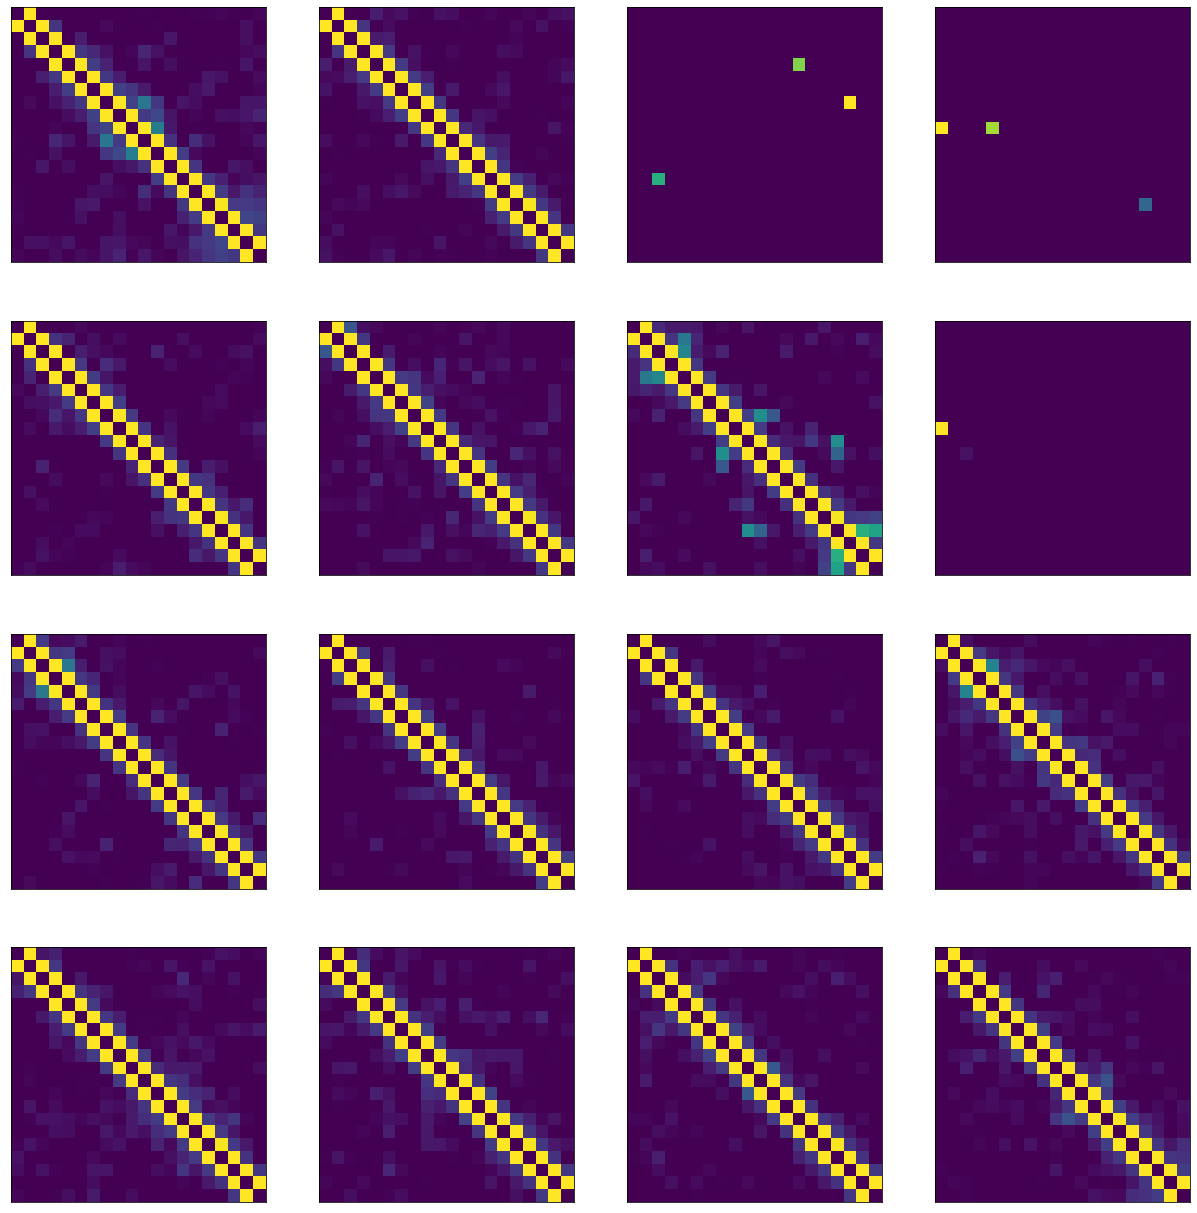

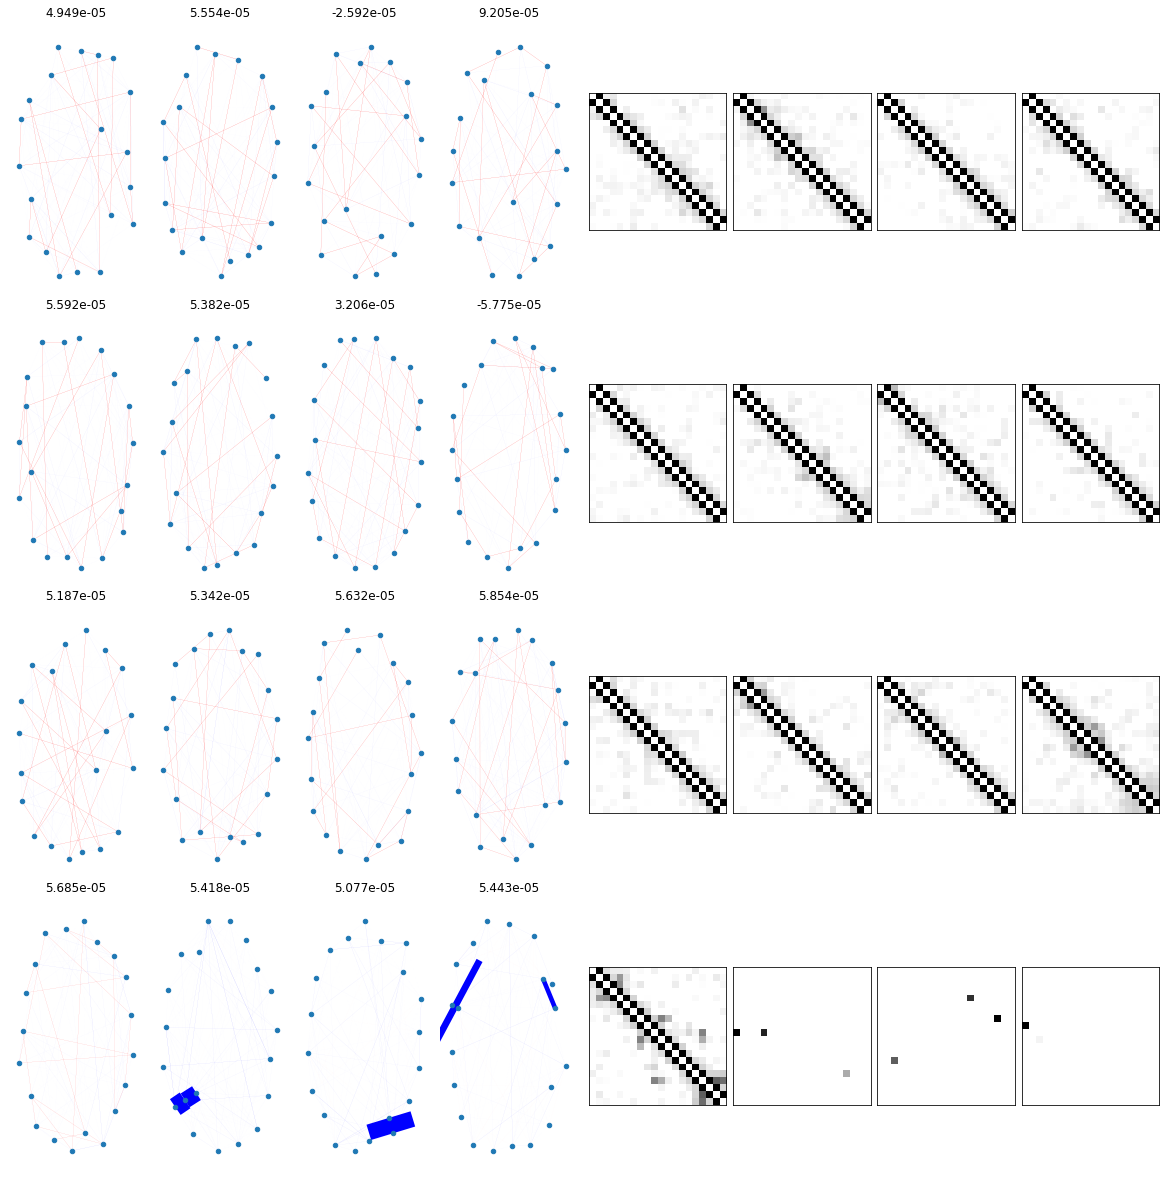

In [42]:
display_dictionary(W = W, figsize = [20,20])

display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 150, 
                       fig_size = [20,20], 
                       show_importance = True)

In [31]:
# SDL_BCD_feature
data_scale=10
results_dict_list40 = []
iteration1 = 200
r = 16

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class40 = SDL_BCD(X = [X40_train.T/data_scale, Y40_train.T],
                                X_test = [X40_test.T/data_scale, Y40_test.T],
                                n_components = r,
                                xi = xi,
                                L1_reg = [0,0,0],
                                L2_reg = [0,0,0],
                                nonnegativity = [True,True,False],
                                full_dim = False)

        results_dict_new40 = SDL_BCD_class40.fit(option = "feature",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 9.17975673e-01  9.70490272e-01  4.51830745e-01  1.64196360e-01
   2.11112454e-01 -2.78723070e-01  7.53097894e-01  5.57348355e-01
   9.37086240e-01 -4.00833676e-03 -3.35203536e-01  1.35447073e-01
   7.19439777e-04 -2.71226267e-01  9.01142370e-01 -2.42971377e-01
  -3.76058993e-02]]


  2%|▋                                          | 3/200 [00:00<00:07, 25.58it/s]

--- Training --- [threshold, AUC] =  [0.372, 0.421]
--- Iteration 0: Training loss --- [Data, Label, Total] = [231.945960.3, 414.612197.3, 414.612197.3]


  8%|███▎                                      | 16/200 [00:00<00:05, 34.95it/s]

--- Training --- [threshold, AUC] =  [0.348, 0.501]
--- Iteration 10: Training loss --- [Data, Label, Total] = [319.288459.3, 409.208325.3, 409.208325.3]


 13%|█████▍                                    | 26/200 [00:00<00:04, 38.10it/s]

--- Training --- [threshold, AUC] =  [0.271, 0.541]
--- Iteration 20: Training loss --- [Data, Label, Total] = [330.111402.3, 403.364883.3, 403.364883.3]


 18%|███████▌                                  | 36/200 [00:00<00:03, 41.26it/s]

--- Training --- [threshold, AUC] =  [0.229, 0.571]
--- Iteration 30: Training loss --- [Data, Label, Total] = [337.024709.3, 408.524256.3, 408.524256.3]


 23%|█████████▋                                | 46/200 [00:01<00:03, 41.04it/s]

--- Training --- [threshold, AUC] =  [0.198, 0.598]
--- Iteration 40: Training loss --- [Data, Label, Total] = [342.280261.3, 417.675214.3, 417.675214.3]


 28%|███████████▊                              | 56/200 [00:01<00:03, 42.89it/s]

--- Training --- [threshold, AUC] =  [0.178, 0.622]
--- Iteration 50: Training loss --- [Data, Label, Total] = [346.297053.3, 425.867767.3, 425.867767.3]


 33%|█████████████▊                            | 66/200 [00:01<00:03, 43.37it/s]

--- Training --- [threshold, AUC] =  [0.164, 0.64]
--- Iteration 60: Training loss --- [Data, Label, Total] = [349.277648.3, 433.727737.3, 433.727737.3]


 38%|███████████████▉                          | 76/200 [00:01<00:02, 42.55it/s]

--- Training --- [threshold, AUC] =  [0.152, 0.662]
--- Iteration 70: Training loss --- [Data, Label, Total] = [352.449526.3, 441.501591.3, 441.501591.3]


 43%|██████████████████                        | 86/200 [00:02<00:02, 42.57it/s]

--- Training --- [threshold, AUC] =  [0.141, 0.68]
--- Iteration 80: Training loss --- [Data, Label, Total] = [355.314762.3, 449.657746.3, 449.657746.3]


 48%|████████████████████▏                     | 96/200 [00:02<00:02, 43.90it/s]

--- Training --- [threshold, AUC] =  [0.134, 0.698]
--- Iteration 90: Training loss --- [Data, Label, Total] = [357.485621.3, 455.668769.3, 455.668769.3]


 53%|█████████████████████▋                   | 106/200 [00:02<00:02, 44.48it/s]

--- Training --- [threshold, AUC] =  [0.127, 0.713]
--- Iteration 100: Training loss --- [Data, Label, Total] = [359.336266.3, 461.984336.3, 461.984336.3]


 58%|███████████████████████▊                 | 116/200 [00:02<00:01, 43.76it/s]

--- Training --- [threshold, AUC] =  [0.12, 0.726]
--- Iteration 110: Training loss --- [Data, Label, Total] = [360.901536.3, 468.660453.3, 468.660453.3]


 63%|█████████████████████████▊               | 126/200 [00:03<00:01, 43.14it/s]

--- Training --- [threshold, AUC] =  [0.115, 0.735]
--- Iteration 120: Training loss --- [Data, Label, Total] = [362.339493.3, 474.815809.3, 474.815809.3]


 68%|███████████████████████████▉             | 136/200 [00:03<00:01, 44.09it/s]

--- Training --- [threshold, AUC] =  [0.11, 0.743]
--- Iteration 130: Training loss --- [Data, Label, Total] = [363.413170.3, 480.593581.3, 480.593581.3]


 73%|█████████████████████████████▉           | 146/200 [00:03<00:01, 44.84it/s]

--- Training --- [threshold, AUC] =  [0.105, 0.752]
--- Iteration 140: Training loss --- [Data, Label, Total] = [364.413363.3, 486.715609.3, 486.715609.3]


 78%|████████████████████████████████▏        | 157/200 [00:03<00:00, 45.92it/s]

--- Training --- [threshold, AUC] =  [0.1, 0.762]
--- Iteration 150: Training loss --- [Data, Label, Total] = [365.672839.3, 492.970422.3, 492.970422.3]


 84%|██████████████████████████████████▏      | 167/200 [00:04<00:00, 39.11it/s]

--- Training --- [threshold, AUC] =  [0.096, 0.769]
--- Iteration 160: Training loss --- [Data, Label, Total] = [366.438950.3, 498.600188.3, 498.600188.3]


 88%|███████████████████████████████████▉     | 175/200 [00:04<00:00, 36.92it/s]

--- Training --- [threshold, AUC] =  [0.092, 0.776]
--- Iteration 170: Training loss --- [Data, Label, Total] = [367.330777.3, 503.944276.3, 503.944276.3]


 93%|██████████████████████████████████████▏  | 186/200 [00:04<00:00, 41.65it/s]

--- Training --- [threshold, AUC] =  [0.089, 0.782]
--- Iteration 180: Training loss --- [Data, Label, Total] = [368.117746.3, 508.727634.3, 508.727634.3]


 98%|████████████████████████████████████████▏| 196/200 [00:04<00:00, 38.52it/s]

--- Training --- [threshold, AUC] =  [0.086, 0.786]
--- Iteration 190: Training loss --- [Data, Label, Total] = [368.781485.3, 513.668872.3, 513.668872.3]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 40.86it/s]


!!! pred_type naive
initial loading beta [[-0.47724714 -0.07292729  0.65987617 -0.28675625 -0.52457501 -0.67622921
   0.41504841 -0.75323968 -0.12886051  0.67230603 -0.15958387  0.13090516
   0.23090981  0.16842331  0.14917988  0.82695056 -0.40096271]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.467, 0.422]
--- Iteration 0: Training loss --- [Data, Label, Total] = [242.092666.3, 450.130357.3, 450.130357.3]


  5%|██                                        | 10/200 [00:00<00:05, 36.38it/s]


--- Training --- [threshold, AUC] =  [0.987, 0.612]
--- Iteration 10: Training loss --- [Data, Label, Total] = [315.039862.3, 2085.489615.3, 2085.489615.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.48478201  0.40384169  0.52522964  0.88494322 -0.37915372 -0.37033639
  -0.75005998  0.2747912   0.92781759 -0.61419734 -0.03275123 -0.06395893
  -0.29256129 -0.73436269 -0.62895774  0.42767973  0.66560937]]


  4%|█▉                                         | 9/200 [00:00<00:04, 39.77it/s]

--- Training --- [threshold, AUC] =  [0.308, 0.423]
--- Iteration 0: Training loss --- [Data, Label, Total] = [215.938634.3, 403.969573.3, 425.563437.3]


  9%|███▊                                      | 18/200 [00:00<00:04, 42.24it/s]

--- Training --- [threshold, AUC] =  [0.218, 0.484]
--- Iteration 10: Training loss --- [Data, Label, Total] = [271.051233.3, 411.250957.3, 438.356080.3]


 14%|█████▉                                    | 28/200 [00:00<00:03, 43.74it/s]

--- Training --- [threshold, AUC] =  [0.141, 0.526]
--- Iteration 20: Training loss --- [Data, Label, Total] = [260.443850.3, 449.418787.3, 475.463172.3]


 19%|███████▉                                  | 38/200 [00:00<00:04, 38.12it/s]

--- Training --- [threshold, AUC] =  [0.116, 0.553]
--- Iteration 30: Training loss --- [Data, Label, Total] = [248.067121.3, 472.633606.3, 497.440319.3]


 21%|████████▊                                 | 42/200 [00:01<00:05, 31.36it/s]

--- Training --- [threshold, AUC] =  [0.102, 0.583]
--- Iteration 40: Training loss --- [Data, Label, Total] = [234.296383.3, 490.613018.3, 514.042657.3]


 29%|████████████▏                             | 58/200 [00:01<00:04, 32.61it/s]

--- Training --- [threshold, AUC] =  [0.09, 0.609]
--- Iteration 50: Training loss --- [Data, Label, Total] = [222.265764.3, 507.621853.3, 529.848429.3]


 33%|█████████████▊                            | 66/200 [00:01<00:04, 32.83it/s]

--- Training --- [threshold, AUC] =  [0.082, 0.634]
--- Iteration 60: Training loss --- [Data, Label, Total] = [209.072289.3, 521.803117.3, 542.710346.3]


 37%|███████████████▌                          | 74/200 [00:02<00:03, 34.51it/s]

--- Training --- [threshold, AUC] =  [0.075, 0.659]
--- Iteration 70: Training loss --- [Data, Label, Total] = [197.695072.3, 535.477976.3, 555.247483.3]


 43%|██████████████████                        | 86/200 [00:02<00:03, 30.61it/s]

--- Training --- [threshold, AUC] =  [0.07, 0.676]
--- Iteration 80: Training loss --- [Data, Label, Total] = [185.734324.3, 546.687813.3, 565.261245.3]


 50%|████████████████████▊                     | 99/200 [00:02<00:02, 34.32it/s]

--- Training --- [threshold, AUC] =  [0.065, 0.696]
--- Iteration 90: Training loss --- [Data, Label, Total] = [173.827084.3, 557.806982.3, 575.189690.3]


 54%|█████████████████████▉                   | 107/200 [00:03<00:02, 31.35it/s]

--- Training --- [threshold, AUC] =  [0.061, 0.717]
--- Iteration 100: Training loss --- [Data, Label, Total] = [162.659201.3, 567.182451.3, 583.448371.3]


 57%|███████████████████████▌                 | 115/200 [00:03<00:02, 30.08it/s]

--- Training --- [threshold, AUC] =  [0.058, 0.729]
--- Iteration 110: Training loss --- [Data, Label, Total] = [153.175364.3, 574.277090.3, 589.594626.3]


 65%|██████████████████████████▋              | 130/200 [00:03<00:01, 39.72it/s]

--- Training --- [threshold, AUC] =  [0.056, 0.743]
--- Iteration 120: Training loss --- [Data, Label, Total] = [143.620198.3, 581.856659.3, 596.218679.3]


 70%|████████████████████████████▋            | 140/200 [00:04<00:01, 42.80it/s]

--- Training --- [threshold, AUC] =  [0.053, 0.755]
--- Iteration 130: Training loss --- [Data, Label, Total] = [133.774087.3, 589.196279.3, 602.573687.3]


 72%|█████████████████████████████▋           | 145/200 [00:04<00:01, 42.50it/s]

--- Training --- [threshold, AUC] =  [0.052, 0.763]
--- Iteration 140: Training loss --- [Data, Label, Total] = [124.214982.3, 594.848928.3, 607.270426.3]


 80%|████████████████████████████████▌        | 159/200 [00:04<00:01, 39.74it/s]

--- Training --- [threshold, AUC] =  [0.05, 0.771]
--- Iteration 150: Training loss --- [Data, Label, Total] = [115.449899.3, 600.586639.3, 612.131629.3]


 85%|██████████████████████████████████▊      | 170/200 [00:04<00:00, 43.38it/s]

--- Training --- [threshold, AUC] =  [0.048, 0.778]
--- Iteration 160: Training loss --- [Data, Label, Total] = [107.600486.3, 605.108911.3, 615.868960.3]


 90%|████████████████████████████████████▉    | 180/200 [00:05<00:00, 44.06it/s]

--- Training --- [threshold, AUC] =  [0.047, 0.786]
--- Iteration 170: Training loss --- [Data, Label, Total] = [99.350048.3, 610.283039.3, 620.218044.3]


 92%|█████████████████████████████████████▉   | 185/200 [00:05<00:00, 41.39it/s]

--- Training --- [threshold, AUC] =  [0.046, 0.791]
--- Iteration 180: Training loss --- [Data, Label, Total] = [92.190160.3, 614.959476.3, 624.178492.3]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 36.41it/s]

--- Training --- [threshold, AUC] =  [0.045, 0.797]
--- Iteration 190: Training loss --- [Data, Label, Total] = [85.909084.3, 619.517200.3, 628.108109.3]
!!! pred_type naive


initial loading beta [[ 0.24917784 -0.26792365 -0.45730817 -0.87418368  0.6080727   0.15778923
  -0.94421657 -0.91177126  0.54263522  0.70455785  0.42447423 -0.5345869
   0.42839426  0.1761707   0.95859014  0.87769436 -0.16801918]]


  2%|█                                          | 5/200 [00:00<00:04, 41.98it/s]

--- Training --- [threshold, AUC] =  [0.3, 0.424]
--- Iteration 0: Training loss --- [Data, Label, Total] = [219.168027.3, 403.434575.3, 425.351377.3]


  5%|██                                        | 10/200 [00:00<00:05, 34.09it/s]


--- Training --- [threshold, AUC] =  [0.715, 0.641]
--- Iteration 10: Training loss --- [Data, Label, Total] = [259.001775.3, 670.539216.3, 696.439393.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.59377927  0.36081525 -0.89892165  0.15501251  0.42175795  0.90633053
   0.41971762 -0.62836993 -0.69092314  0.52006082  0.03060637 -0.67514819
  -0.55190226  0.17506717 -0.18126088  0.99702054 -0.1430952 ]]


  2%|▊                                          | 4/200 [00:00<00:06, 31.91it/s]

--- Training --- [threshold, AUC] =  [0.178, 0.577]
--- Iteration 0: Training loss --- [Data, Label, Total] = [210.640527.3, 426.052097.3, 636.692624.3]


  5%|██                                        | 10/200 [00:00<00:05, 33.66it/s]


--- Training --- [threshold, AUC] =  [0.001, 0.615]
--- Iteration 10: Training loss --- [Data, Label, Total] = [173.766557.3, 1326.214703.3, 1499.981260.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.20414159  0.87047053 -0.61555726 -0.39208831  0.34885207 -0.12397285
  -0.95159827 -0.64964273 -0.0921264  -0.11322112  0.41245186  0.81704761
   0.60898664 -0.77608618 -0.89719873  0.73913509 -0.92182796]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.234, 0.576]
--- Iteration 0: Training loss --- [Data, Label, Total] = [222.294555.3, 407.546977.3, 629.841532.3]


  5%|██                                        | 10/200 [00:00<00:05, 35.78it/s]


--- Training --- [threshold, AUC] =  [0.007, 0.736]
--- Iteration 10: Training loss --- [Data, Label, Total] = [167.308755.3, 948.363919.3, 1115.672674.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.09522567 -0.8146568  -0.7972611  -0.76999111 -0.04074965  0.96853411
  -0.83910049 -0.18762784 -0.97002596 -0.71453131 -0.34768823 -0.27790217
  -0.08026916  0.09008062 -0.67039256 -0.61584094 -0.37063746]]


  5%|██                                        | 10/200 [00:00<00:04, 43.46it/s]

--- Training --- [threshold, AUC] =  [0.331, 0.423]
--- Iteration 0: Training loss --- [Data, Label, Total] = [187.532955.3, 406.403062.3, 1344.067835.3]


  8%|███▏                                      | 15/200 [00:00<00:04, 38.75it/s]

--- Training --- [threshold, AUC] =  [0.009, 0.556]
--- Iteration 10: Training loss --- [Data, Label, Total] = [95.812840.3, 907.969265.3, 1387.033465.3]


 15%|██████▎                                   | 30/200 [00:00<00:03, 42.70it/s]

--- Training --- [threshold, AUC] =  [0.009, 0.66]
--- Iteration 20: Training loss --- [Data, Label, Total] = [43.862580.3, 900.879575.3, 1120.192473.3]


 18%|███████▎                                  | 35/200 [00:00<00:04, 41.00it/s]

--- Training --- [threshold, AUC] =  [0.013, 0.63]
--- Iteration 30: Training loss --- [Data, Label, Total] = [9.786157.3, 833.521774.3, 882.452559.3]


 24%|██████████▎                               | 49/200 [00:01<00:03, 37.81it/s]

--- Training --- [threshold, AUC] =  [0.014, 0.734]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.136101.3, 821.241556.3, 821.922059.3]


 30%|████████████▍                             | 59/200 [00:01<00:03, 40.71it/s]

--- Training --- [threshold, AUC] =  [0.014, 0.753]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.113882.3, 820.449908.3, 821.019318.3]


 34%|██████████████▍                           | 69/200 [00:01<00:03, 41.17it/s]

--- Training --- [threshold, AUC] =  [0.014, 0.757]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.112287.3, 822.506164.3, 823.067599.3]


 40%|████████████████▌                         | 79/200 [00:01<00:02, 42.95it/s]

--- Training --- [threshold, AUC] =  [0.014, 0.76]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.109768.3, 826.450241.3, 826.999083.3]


 45%|██████████████████▉                       | 90/200 [00:02<00:02, 46.55it/s]

--- Training --- [threshold, AUC] =  [0.014, 0.763]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.109675.3, 830.738254.3, 831.286630.3]


 48%|███████████████████▉                      | 95/200 [00:02<00:02, 45.44it/s]

--- Training --- [threshold, AUC] =  [0.013, 0.765]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.109594.3, 834.332861.3, 834.880832.3]


 54%|█████████████████████▉                   | 107/200 [00:02<00:01, 47.79it/s]

--- Training --- [threshold, AUC] =  [0.013, 0.767]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.109526.3, 838.394356.3, 838.941986.3]
--- Training --- [threshold, AUC] =  [0.013, 0.768]

 59%|████████████████████████▏                | 118/200 [00:02<00:01, 48.44it/s]


--- Iteration 110: Training loss --- [Data, Label, Total] = [0.109461.3, 842.151978.3, 842.699285.3]


 64%|██████████████████████████▍              | 129/200 [00:02<00:01, 49.13it/s]

--- Training --- [threshold, AUC] =  [0.013, 0.769]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.109397.3, 846.325886.3, 846.872869.3]


 70%|████████████████████████████▋            | 140/200 [00:03<00:01, 47.68it/s]

--- Training --- [threshold, AUC] =  [0.012, 0.77]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.109329.3, 849.945603.3, 850.492245.3]


 72%|█████████████████████████████▋           | 145/200 [00:03<00:01, 47.29it/s]

--- Training --- [threshold, AUC] =  [0.012, 0.771]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.109270.3, 852.575922.3, 853.122271.3]


 78%|████████████████████████████████▏        | 157/200 [00:03<00:00, 48.70it/s]

--- Training --- [threshold, AUC] =  [0.012, 0.772]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.109216.3, 855.360905.3, 855.906984.3]


 84%|██████████████████████████████████▏      | 167/200 [00:03<00:00, 47.18it/s]

--- Training --- [threshold, AUC] =  [0.012, 0.773]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.109159.3, 857.793346.3, 858.339142.3]


 88%|████████████████████████████████████▎    | 177/200 [00:04<00:00, 46.08it/s]

--- Training --- [threshold, AUC] =  [0.012, 0.774]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.109105.3, 860.486889.3, 861.032413.3]


 94%|██████████████████████████████████████▎  | 187/200 [00:04<00:00, 45.75it/s]

--- Training --- [threshold, AUC] =  [0.011, 0.774]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.109050.3, 863.790122.3, 864.335370.3]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 44.08it/s]

--- Training --- [threshold, AUC] =  [0.011, 0.775]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.109004.3, 866.955398.3, 867.500417.3]
!!! pred_type naive


initial loading beta [[-0.0761175   0.01193682  0.16705464 -0.80296095 -0.84048708 -0.75835591
  -0.17279885  0.32207612 -0.08413468 -0.29931515 -0.96751103 -0.13744102
  -0.47010243 -0.09385412  0.0575396  -0.79092152  0.64890297]]


  2%|█                                          | 5/200 [00:00<00:04, 40.59it/s]

--- Training --- [threshold, AUC] =  [0.319, 0.422]
--- Iteration 0: Training loss --- [Data, Label, Total] = [186.452952.3, 404.913632.3, 1337.178390.3]


 10%|████▏                                     | 20/200 [00:00<00:04, 42.90it/s]

--- Training --- [threshold, AUC] =  [0.192, 0.566]
--- Iteration 10: Training loss --- [Data, Label, Total] = [94.375669.3, 419.689158.3, 891.567502.3]


 15%|██████▎                                   | 30/200 [00:00<00:03, 43.36it/s]

--- Training --- [threshold, AUC] =  [0.093, 0.709]
--- Iteration 20: Training loss --- [Data, Label, Total] = [50.508844.3, 502.638107.3, 755.182325.3]


 20%|████████▍                                 | 40/200 [00:00<00:03, 44.66it/s]

--- Training --- [threshold, AUC] =  [0.098, 0.714]
--- Iteration 30: Training loss --- [Data, Label, Total] = [8.113438.3, 495.109099.3, 535.676290.3]


 25%|██████████▌                               | 50/200 [00:01<00:03, 43.82it/s]

--- Training --- [threshold, AUC] =  [0.093, 0.742]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.426764.3, 503.033458.3, 505.167279.3]


 30%|████████████▌                             | 60/200 [00:01<00:03, 43.84it/s]

--- Training --- [threshold, AUC] =  [0.087, 0.772]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.112395.3, 513.328394.3, 513.890370.3]


 32%|█████████████▋                            | 65/200 [00:01<00:03, 42.50it/s]

--- Training --- [threshold, AUC] =  [0.08, 0.782]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.109728.3, 524.613035.3, 525.161677.3]


 38%|███████████████▉                          | 76/200 [00:01<00:02, 43.68it/s]

--- Training --- [threshold, AUC] =  [0.075, 0.783]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.109248.3, 534.423099.3, 534.969340.3]


 43%|██████████████████                        | 86/200 [00:01<00:02, 43.81it/s]

--- Training --- [threshold, AUC] =  [0.071, 0.783]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.109086.3, 542.691183.3, 543.236616.3]


 48%|████████████████████▏                     | 96/200 [00:02<00:02, 43.70it/s]

--- Training --- [threshold, AUC] =  [0.068, 0.784]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.108949.3, 550.243247.3, 550.787993.3]


 53%|█████████████████████▋                   | 106/200 [00:02<00:02, 44.20it/s]

--- Training --- [threshold, AUC] =  [0.065, 0.784]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.108801.3, 558.242066.3, 558.786073.3]


 58%|███████████████████████▊                 | 116/200 [00:02<00:01, 43.55it/s]

--- Training --- [threshold, AUC] =  [0.062, 0.784]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.108647.3, 564.849449.3, 565.392683.3]


 63%|█████████████████████████▊               | 126/200 [00:02<00:01, 44.21it/s]

--- Training --- [threshold, AUC] =  [0.06, 0.784]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.108493.3, 571.350497.3, 571.892964.3]


 68%|███████████████████████████▉             | 136/200 [00:03<00:01, 44.05it/s]

--- Training --- [threshold, AUC] =  [0.057, 0.785]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.108346.3, 578.320628.3, 578.862357.3]


 73%|█████████████████████████████▉           | 146/200 [00:03<00:01, 43.92it/s]

--- Training --- [threshold, AUC] =  [0.055, 0.785]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.108189.3, 584.889867.3, 585.430812.3]


 78%|███████████████████████████████▉         | 156/200 [00:03<00:01, 43.96it/s]

--- Training --- [threshold, AUC] =  [0.053, 0.785]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.108028.3, 591.216212.3, 591.756351.3]


 83%|██████████████████████████████████       | 166/200 [00:03<00:00, 44.03it/s]

--- Training --- [threshold, AUC] =  [0.051, 0.785]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.107866.3, 596.465953.3, 597.005284.3]


 88%|████████████████████████████████████     | 176/200 [00:04<00:00, 44.24it/s]

--- Training --- [threshold, AUC] =  [0.049, 0.785]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.107699.3, 601.947246.3, 602.485743.3]


 93%|██████████████████████████████████████▏  | 186/200 [00:04<00:00, 44.40it/s]

--- Training --- [threshold, AUC] =  [0.048, 0.785]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.107525.3, 607.538162.3, 608.075789.3]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 43.40it/s]

--- Training --- [threshold, AUC] =  [0.047, 0.785]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.107347.3, 611.802194.3, 612.338931.3]
!!! pred_type naive


initial loading beta [[-0.20130175 -0.96427465  0.54370604  0.45456553 -0.95238494  0.24049036
  -0.77427212  0.99307504  0.23489723  0.30266143 -0.98940536 -0.58214897
   0.76317657  0.93657444  0.8248446   0.01727289 -0.39792031]]


  2%|█                                          | 5/200 [00:00<00:04, 42.11it/s]

--- Training --- [threshold, AUC] =  [0.34, 0.579]
--- Iteration 0: Training loss --- [Data, Label, Total] = [184.970764.3, 407.765632.3, 2257.473271.3]


  8%|███▎                                      | 16/200 [00:00<00:04, 45.19it/s]

--- Training --- [threshold, AUC] =  [0.556, 0.5]
--- Iteration 10: Training loss --- [Data, Label, Total] = [99.668660.3, 505.156439.3, 1501.843043.3]


 13%|█████▍                                    | 26/200 [00:00<00:03, 44.44it/s]

--- Training --- [threshold, AUC] =  [0.238, 0.722]
--- Iteration 20: Training loss --- [Data, Label, Total] = [56.844543.3, 406.956458.3, 975.401892.3]


 18%|███████▌                                  | 36/200 [00:00<00:03, 43.14it/s]

--- Training --- [threshold, AUC] =  [0.201, 0.728]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.153684.3, 416.518289.3, 428.055127.3]


 23%|█████████▋                                | 46/200 [00:01<00:03, 43.97it/s]

--- Training --- [threshold, AUC] =  [0.172, 0.768]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.110994.3, 429.229979.3, 430.339919.3]


 28%|███████████▊                              | 56/200 [00:01<00:03, 43.22it/s]

--- Training --- [threshold, AUC] =  [0.153, 0.774]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.110169.3, 440.501702.3, 441.603391.3]


 34%|██████████████                            | 67/200 [00:01<00:02, 44.92it/s]

--- Training --- [threshold, AUC] =  [0.141, 0.776]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.109880.3, 449.519495.3, 450.618293.3]


 38%|████████████████▏                         | 77/200 [00:01<00:02, 43.90it/s]

--- Training --- [threshold, AUC] =  [0.129, 0.776]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.109657.3, 459.642668.3, 460.739236.3]


 44%|██████████████████▍                       | 88/200 [00:02<00:02, 46.38it/s]

--- Training --- [threshold, AUC] =  [0.119, 0.776]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.109445.3, 470.038393.3, 471.132843.3]


 49%|████████████████████▌                     | 98/200 [00:02<00:02, 45.27it/s]

--- Training --- [threshold, AUC] =  [0.11, 0.777]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.109239.3, 479.742063.3, 480.834455.3]


 54%|██████████████████████▏                  | 108/200 [00:02<00:02, 45.22it/s]

--- Training --- [threshold, AUC] =  [0.103, 0.777]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.109051.3, 488.364457.3, 489.454967.3]


 60%|████████████████████████▍                | 119/200 [00:02<00:01, 46.96it/s]

--- Training --- [threshold, AUC] =  [0.098, 0.777]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.108858.3, 495.909614.3, 496.998195.3]


 65%|██████████████████████████▋              | 130/200 [00:02<00:01, 48.33it/s]

--- Training --- [threshold, AUC] =  [0.093, 0.777]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.108677.3, 503.203626.3, 504.290401.3]


 68%|███████████████████████████▋             | 135/200 [00:03<00:01, 47.65it/s]

--- Training --- [threshold, AUC] =  [0.088, 0.777]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.108496.3, 510.387142.3, 511.472101.3]


 73%|█████████████████████████████▉           | 146/200 [00:03<00:01, 47.16it/s]

--- Training --- [threshold, AUC] =  [0.084, 0.777]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.108310.3, 517.566298.3, 518.649401.3]


 78%|███████████████████████████████▉         | 156/200 [00:03<00:00, 45.61it/s]

--- Training --- [threshold, AUC] =  [0.08, 0.776]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.108111.3, 524.856416.3, 525.937529.3]


 83%|██████████████████████████████████       | 166/200 [00:03<00:00, 47.02it/s]

--- Training --- [threshold, AUC] =  [0.077, 0.776]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.107924.3, 531.518953.3, 532.598194.3]


 88%|████████████████████████████████████     | 176/200 [00:03<00:00, 46.14it/s]

--- Training --- [threshold, AUC] =  [0.074, 0.776]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.107734.3, 538.032453.3, 539.109797.3]


 93%|██████████████████████████████████████▏  | 186/200 [00:04<00:00, 45.57it/s]

--- Training --- [threshold, AUC] =  [0.071, 0.776]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.107536.3, 543.768375.3, 544.843731.3]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 44.92it/s]

--- Training --- [threshold, AUC] =  [0.068, 0.776]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.107335.3, 549.353440.3, 550.426790.3]
!!! pred_type naive


initial loading beta [[-0.85505623 -0.98291311  0.96314527 -0.69898833 -0.02737739 -0.97692309
  -0.4735127  -0.75085468 -0.36837504  0.11979643  0.45884881 -0.90587565
   0.78743983  0.89289199 -0.30345685 -0.16788781  0.91782642]]


  2%|█                                          | 5/200 [00:00<00:04, 42.22it/s]

--- Training --- [threshold, AUC] =  [0.18, 0.58]
--- Iteration 0: Training loss --- [Data, Label, Total] = [183.562016.3, 424.951738.3, 2260.571897.3]


 10%|████▏                                     | 20/200 [00:00<00:04, 42.81it/s]

--- Training --- [threshold, AUC] =  [0.009, 0.656]
--- Iteration 10: Training loss --- [Data, Label, Total] = [102.793544.3, 918.233103.3, 1946.168538.3]


 15%|██████▎                                   | 30/200 [00:00<00:03, 43.54it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.704]
--- Iteration 20: Training loss --- [Data, Label, Total] = [45.794055.3, 955.617222.3, 1413.557773.3]


 18%|███████▎                                  | 35/200 [00:00<00:04, 41.21it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.654]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.270033.3, 952.977742.3, 955.678069.3]


 25%|██████████▌                               | 50/200 [00:01<00:03, 42.47it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.763]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.118540.3, 947.401683.3, 948.587084.3]


 30%|████████████▌                             | 60/200 [00:01<00:03, 42.78it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.766]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.118000.3, 947.124058.3, 948.304061.3]


 32%|█████████████▋                            | 65/200 [00:01<00:03, 42.40it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.766]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.110109.3, 947.167490.3, 948.268575.3]


 38%|████████████████▏                         | 77/200 [00:01<00:02, 45.40it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.768]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.109947.3, 949.167816.3, 950.267284.3]


 44%|██████████████████▍                       | 88/200 [00:02<00:02, 47.08it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.768]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.109788.3, 951.009705.3, 952.107588.3]


 49%|████████████████████▌                     | 98/200 [00:02<00:02, 46.59it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.77]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.109625.3, 953.174147.3, 954.270402.3]


 55%|██████████████████████▎                  | 109/200 [00:02<00:01, 46.24it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.77]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.109466.3, 955.353581.3, 956.448244.3]


 60%|████████████████████████▌                | 120/200 [00:02<00:01, 46.68it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.772]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.109305.3, 955.680301.3, 956.773352.3]


 62%|█████████████████████████▋               | 125/200 [00:02<00:01, 45.98it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.773]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.109126.3, 956.943600.3, 958.034864.3]


 68%|███████████████████████████▉             | 136/200 [00:03<00:01, 45.67it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.774]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.108945.3, 957.741048.3, 958.830501.3]


 74%|██████████████████████████████▏          | 147/200 [00:03<00:01, 47.24it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.774]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.108738.3, 960.062309.3, 961.149688.3]


 78%|████████████████████████████████▏        | 157/200 [00:03<00:00, 45.59it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.775]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.108521.3, 961.633632.3, 962.718846.3]


 84%|██████████████████████████████████▏      | 167/200 [00:03<00:00, 45.42it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.776]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.108307.3, 962.835884.3, 963.918951.3]


 89%|████████████████████████████████████▍    | 178/200 [00:04<00:00, 46.74it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.777]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.108071.3, 963.881537.3, 964.962243.3]


 94%|██████████████████████████████████████▌  | 188/200 [00:04<00:00, 45.96it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.778]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.107824.3, 964.710157.3, 965.788397.3]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 44.45it/s]

--- Training --- [threshold, AUC] =  [0.007, 0.779]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.107562.3, 966.064849.3, 967.140467.3]
!!! pred_type naive


In [33]:
results_dict_new40

{'xi': 10,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 16,
 'loading': [array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
          0.00000000e+000, 0.00000000e+000, 8.43651902e-313],
         [6.26072557e-002, 3.76772442e-004, 3.28057795e-004, ...,
          3.46824223e-004, 3.40483550e-004, 2.58949068e-004],
         [4.19927410e-002, 0.00000000e+000, 0.00000000e+000, ...,
          6.12559733e-005, 5.76558582e-005, 0.00000000e+000],
         ...,
         [1.23824244e-002, 3.66322333e-004, 0.00000000e+000, ...,
          2.68744851e-004, 1.57778206e-004, 0.00000000e+000],
         [6.26072557e-002, 3.76772442e-004, 3.28057795e-004, ...,
          3.46824223e-004, 3.40483550e-004, 2.58949068e-004],
         [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
          0.00000000e+000, 0.00000000e+000, 5.87803490e-313]]),
  array([[-9.22939727e-01,  3.69116429e-02,  1.23968711e-04,
           1.74932472e-04,  1

In [32]:
W = results_dict_new40['loading'][0]
coeff = results_dict_new40['loading'][1][0]
H = results_dict_new40['code']

print('Accuracy: {}'.format(results_dict_new40['Accuracy']))
print('Training RRE: {}'.format(results_dict_new40['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new40['Relative_reconstruction_loss (test)']))

Accuracy: 0.5911111111111111
Training RRE: 0.3317515893627887
Testing RRE: 0.8575248643698835


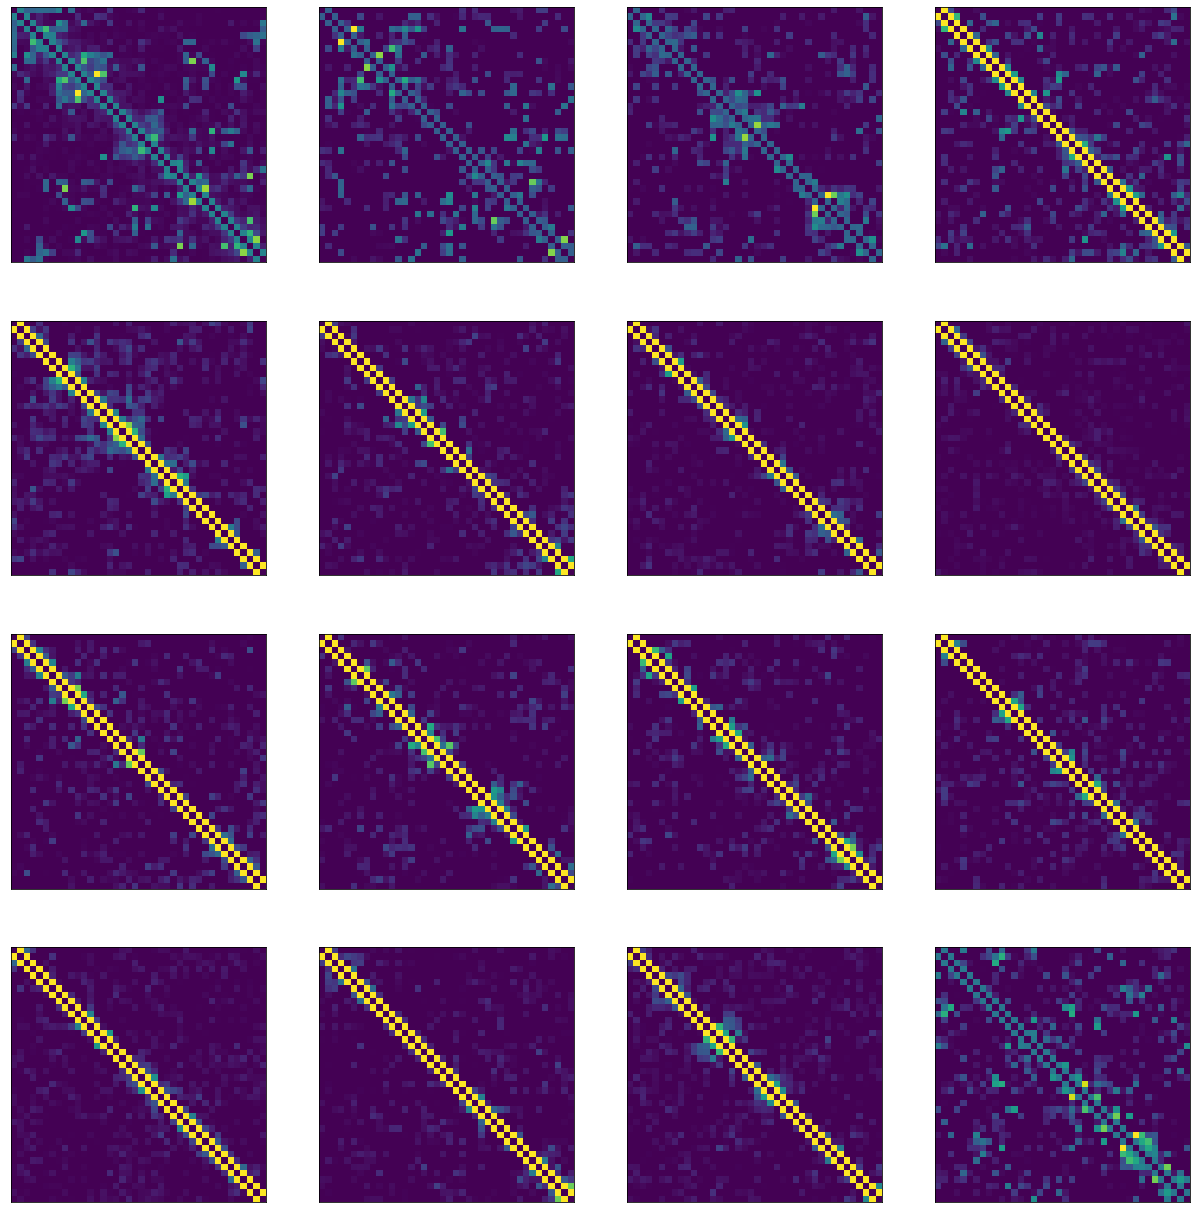

In [34]:
display_dictionary(W = W, figsize = [20,20])

display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 150, 
                       fig_size = [20,20], 
                       show_importance = True)

In [43]:
# SDL_BCD_filter
data_scale=10
results_dict_list40filter = []
iteration1 = 200
r = 16

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class40filter = SDL_BCD(X = [X40_train.T/data_scale, Y40_train.T],
                                X_test = [X40_test.T/data_scale, Y40_test.T],
                                n_components = r,
                                xi = xi,
                                L1_reg = [0,0,0],
                                L2_reg = [0,0,0],
                                nonnegativity = [True,True,False],
                                full_dim = False)

        results_dict_new40filter = SDL_BCD_class40filter.fit(option = "filter",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.79390836  0.27763869  0.294753    0.18480172  0.45411028 -0.84242313
   0.89227553 -0.60129408  0.26481383 -0.8197911   0.58195045  0.54660185
   0.40917872 -0.60203042 -0.78020946  0.64448226 -0.00704001]]


  1%|▍                                          | 2/200 [00:00<00:12, 15.67it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.589]
--- Iteration 0: Training loss --- [Data, Label, Total] = [213.718813.3, 403.042054.3, 403.042054.3]


  6%|██▋                                       | 13/200 [00:00<00:10, 18.51it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.59]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.576205.3, 403.041987.3, 403.041987.3]


 12%|█████                                     | 24/200 [00:01<00:09, 18.89it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.602]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.322303.3, 403.041475.3, 403.041475.3]


 17%|███████▏                                  | 34/200 [00:01<00:08, 20.05it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.625]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.306293.3, 403.040099.3, 403.040099.3]


 22%|█████████                                 | 43/200 [00:02<00:07, 19.88it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.656]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.304283.3, 403.037590.3, 403.037590.3]


 28%|███████████▌                              | 55/200 [00:02<00:07, 18.69it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.686]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.305228.3, 403.033868.3, 403.033868.3]


 32%|█████████████▍                            | 64/200 [00:03<00:06, 19.67it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.711]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.307900.3, 403.029495.3, 403.029495.3]


 37%|███████████████▌                          | 74/200 [00:03<00:06, 19.53it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.728]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.311081.3, 403.025582.3, 403.025582.3]


 42%|█████████████████▋                        | 84/200 [00:04<00:05, 20.46it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.738]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.313855.3, 403.022913.3, 403.022913.3]


 48%|███████████████████▉                      | 95/200 [00:04<00:05, 19.82it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.743]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.315919.3, 403.021422.3, 403.021422.3]


 52%|█████████████████████▎                   | 104/200 [00:05<00:04, 20.43it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.745]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.317351.3, 403.020675.3, 403.020675.3]


 56%|███████████████████████▏                 | 113/200 [00:05<00:04, 20.31it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.746]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.318322.3, 403.020317.3, 403.020317.3]


 62%|█████████████████████████▍               | 124/200 [00:06<00:04, 18.45it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.318978.3, 403.020145.3, 403.020145.3]


 66%|███████████████████████████▎             | 133/200 [00:06<00:03, 17.86it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.319423.3, 403.020061.3, 403.020061.3]


 72%|█████████████████████████████▋           | 145/200 [00:07<00:02, 19.45it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.319730.3, 403.020019.3, 403.020019.3]


 77%|███████████████████████████████▌         | 154/200 [00:07<00:02, 20.62it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.319943.3, 403.019998.3, 403.019998.3]


 82%|█████████████████████████████████▌       | 164/200 [00:08<00:02, 17.66it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.320091.3, 403.019988.3, 403.019988.3]


 87%|███████████████████████████████████▋     | 174/200 [00:09<00:01, 19.58it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.320196.3, 403.019982.3, 403.019982.3]


 92%|█████████████████████████████████████▉   | 185/200 [00:09<00:00, 19.54it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.320271.3, 403.019980.3, 403.019980.3]


 97%|███████████████████████████████████████▊ | 194/200 [00:10<00:00, 19.87it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.320323.3, 403.019978.3, 403.019978.3]


100%|█████████████████████████████████████████| 200/200 [00:10<00:00, 19.20it/s]


!!! pred_type filter
initial loading beta [[ 0.06629576  0.33681878 -0.08089032  0.20500691 -0.95087745 -0.98461711
  -0.35177436 -0.85040395  0.45125774  0.02063958  0.74965043  0.14930301
   0.2899949   0.83080674  0.91074691  0.01231814  0.16993982]]


  1%|▍                                          | 2/200 [00:00<00:10, 18.21it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.587]
--- Iteration 0: Training loss --- [Data, Label, Total] = [215.137349.3, 403.042103.3, 403.042103.3]


  6%|██▋                                       | 13/200 [00:00<00:09, 18.78it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.589]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.559045.3, 403.042035.3, 403.042035.3]


 12%|████▊                                     | 23/200 [00:01<00:09, 18.28it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.601]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.319896.3, 403.041508.3, 403.041508.3]


 18%|███████▎                                  | 35/200 [00:01<00:08, 19.43it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.625]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.305877.3, 403.040118.3, 403.040118.3]


 22%|█████████▏                                | 44/200 [00:02<00:07, 20.52it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.656]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.304394.3, 403.037619.3, 403.037619.3]


 26%|███████████▏                              | 53/200 [00:02<00:07, 20.93it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.686]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.305562.3, 403.033929.3, 403.033929.3]


 32%|█████████████▍                            | 64/200 [00:03<00:07, 18.63it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.711]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.308279.3, 403.029570.3, 403.029570.3]


 36%|███████████████▎                          | 73/200 [00:03<00:07, 17.37it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.728]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.311418.3, 403.025640.3, 403.025640.3]


 42%|█████████████████▊                        | 85/200 [00:04<00:05, 19.84it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.738]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.314111.3, 403.022961.3, 403.022961.3]


 47%|███████████████████▋                      | 94/200 [00:04<00:05, 19.92it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.743]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.316099.3, 403.021457.3, 403.021457.3]


 52%|█████████████████████                    | 103/200 [00:05<00:04, 19.97it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.745]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.317472.3, 403.020700.3, 403.020700.3]


 57%|███████████████████████▎                 | 114/200 [00:05<00:04, 18.84it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.746]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.318403.3, 403.020332.3, 403.020332.3]


 62%|█████████████████████████▍               | 124/200 [00:06<00:04, 17.71it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.319032.3, 403.020153.3, 403.020153.3]


 68%|███████████████████████████▋             | 135/200 [00:07<00:03, 19.85it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.319460.3, 403.020065.3, 403.020065.3]


 72%|█████████████████████████████▌           | 144/200 [00:07<00:02, 21.41it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.319755.3, 403.020021.3, 403.020021.3]


 76%|███████████████████████████████▎         | 153/200 [00:07<00:02, 19.32it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.319960.3, 403.019999.3, 403.019999.3]


 81%|█████████████████████████████████▏       | 162/200 [00:08<00:01, 19.30it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.320103.3, 403.019988.3, 403.019988.3]


 88%|███████████████████████████████████▉     | 175/200 [00:09<00:01, 19.89it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.320204.3, 403.019983.3, 403.019983.3]


 92%|█████████████████████████████████████▋   | 184/200 [00:09<00:00, 20.34it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.320276.3, 403.019980.3, 403.019980.3]


 96%|███████████████████████████████████████▌ | 193/200 [00:09<00:00, 19.89it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.747]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.320327.3, 403.019978.3, 403.019978.3]


100%|█████████████████████████████████████████| 200/200 [00:10<00:00, 19.50it/s]


!!! pred_type filter
initial loading beta [[-0.56818042 -0.37539642  0.91833213 -0.20693642 -0.28859586  0.43033982
  -0.17999552 -0.97782977  0.29066989  0.01370954 -0.97100269  0.82115241
  -0.64059179  0.21413315 -0.44684141  0.82223493  0.23939005]]


  1%|▍                                          | 2/200 [00:00<00:11, 17.54it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.589]
--- Iteration 0: Training loss --- [Data, Label, Total] = [220.760537.3, 403.042138.3, 425.118192.3]


  7%|██▉                                       | 14/200 [00:00<00:09, 20.15it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.59]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.641909.3, 403.042214.3, 403.106405.3]


 12%|█████▎                                    | 25/200 [00:01<00:08, 19.75it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.596]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.278555.3, 403.042019.3, 403.069875.3]


 17%|███████▏                                  | 34/200 [00:01<00:08, 20.22it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.605]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.182888.3, 403.041705.3, 403.059994.3]


 22%|█████████▍                                | 45/200 [00:02<00:07, 19.61it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.614]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.127800.3, 403.041346.3, 403.054126.3]


 27%|███████████▎                              | 54/200 [00:02<00:07, 19.83it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.623]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.111542.3, 403.040913.3, 403.052067.3]


 32%|█████████████▍                            | 64/200 [00:03<00:07, 19.10it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.631]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.107139.3, 403.040395.3, 403.051109.3]


 37%|███████████████▌                          | 74/200 [00:03<00:06, 19.82it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.641]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.105683.3, 403.039801.3, 403.050369.3]


 42%|█████████████████▍                        | 83/200 [00:04<00:06, 18.62it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.65]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.105068.3, 403.039132.3, 403.049638.3]


 47%|███████████████████▋                      | 94/200 [00:04<00:05, 19.02it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.658]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.104740.3, 403.038389.3, 403.048863.3]


 52%|█████████████████████▌                   | 105/200 [00:05<00:04, 19.25it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.666]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.104535.3, 403.037580.3, 403.048033.3]


 56%|███████████████████████▏                 | 113/200 [00:05<00:04, 18.42it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.674]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.104393.3, 403.036710.3, 403.047150.3]


 62%|█████████████████████████▍               | 124/200 [00:06<00:03, 19.06it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.681]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.104290.3, 403.035790.3, 403.046219.3]


 68%|███████████████████████████▋             | 135/200 [00:06<00:03, 19.05it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.687]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.104211.3, 403.034831.3, 403.045252.3]


 72%|█████████████████████████████▎           | 143/200 [00:07<00:03, 17.50it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.693]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.104150.3, 403.033864.3, 403.044279.3]


 77%|███████████████████████████████▌         | 154/200 [00:07<00:02, 19.21it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.7]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.104103.3, 403.032885.3, 403.043295.3]


 82%|█████████████████████████████████▊       | 165/200 [00:08<00:01, 19.29it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.705]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.104066.3, 403.031922.3, 403.042328.3]


 86%|███████████████████████████████████      | 171/200 [00:09<00:02, 13.64it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.709]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.104037.3, 403.030991.3, 403.041395.3]


 92%|█████████████████████████████████████▋   | 184/200 [00:10<00:01, 15.09it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.714]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.104013.3, 403.030099.3, 403.040501.3]


 97%|███████████████████████████████████████▊ | 194/200 [00:10<00:00, 15.60it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.718]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.103995.3, 403.029256.3, 403.039655.3]


100%|█████████████████████████████████████████| 200/200 [00:11<00:00, 18.17it/s]


!!! pred_type filter
initial loading beta [[ 5.97497981e-01 -3.99480287e-01  2.07171724e-01  2.46225076e-01
   7.29189930e-01  5.24902839e-04 -4.50590719e-01  1.84986455e-01
   3.16579051e-01 -1.54256331e-01  8.56936104e-01 -8.54883673e-01
   8.10538421e-01 -8.35491789e-01  3.21898398e-02  2.95356252e-01
   7.10875193e-01]]


  2%|▊                                          | 4/200 [00:00<00:13, 14.88it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.589]
--- Iteration 0: Training loss --- [Data, Label, Total] = [221.633408.3, 403.042175.3, 425.205516.3]


  7%|██▉                                       | 14/200 [00:00<00:11, 15.88it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.589]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.589276.3, 403.042273.3, 403.101201.3]


 12%|████▊                                     | 23/200 [00:01<00:10, 17.61it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.594]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.261761.3, 403.042091.3, 403.068267.3]


 17%|███████▏                                  | 34/200 [00:01<00:08, 19.16it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.602]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.169403.3, 403.041813.3, 403.058753.3]


 22%|█████████                                 | 43/200 [00:02<00:07, 20.41it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.61]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.125859.3, 403.041498.3, 403.054084.3]


 27%|███████████▎                              | 54/200 [00:03<00:08, 18.06it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.618]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.113450.3, 403.041131.3, 403.052476.3]


 32%|█████████████▋                            | 65/200 [00:03<00:06, 19.70it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.626]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.109266.3, 403.040698.3, 403.051625.3]


 37%|███████████████▌                          | 74/200 [00:03<00:05, 21.02it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.633]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.107474.3, 403.040225.3, 403.050973.3]


 42%|█████████████████▍                        | 83/200 [00:04<00:05, 19.81it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.641]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.106533.3, 403.039685.3, 403.050338.3]


 48%|███████████████████▉                      | 95/200 [00:04<00:05, 20.39it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.649]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.105963.3, 403.039092.3, 403.049688.3]


 52%|█████████████████████▎                   | 104/200 [00:05<00:04, 21.07it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.657]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.105586.3, 403.038446.3, 403.049005.3]


 56%|███████████████████████▏                 | 113/200 [00:05<00:04, 21.33it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.663]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.105321.3, 403.037750.3, 403.048282.3]


 62%|█████████████████████████▋               | 125/200 [00:06<00:03, 21.95it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.67]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.105128.3, 403.037009.3, 403.047522.3]


 67%|███████████████████████████▍             | 134/200 [00:06<00:03, 21.94it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.677]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.104982.3, 403.036230.3, 403.046729.3]


 72%|█████████████████████████████▎           | 143/200 [00:07<00:02, 20.42it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.683]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.104871.3, 403.035423.3, 403.045910.3]


 78%|███████████████████████████████▊         | 155/200 [00:07<00:02, 20.79it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.689]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.104783.3, 403.034592.3, 403.045070.3]


 82%|█████████████████████████████████▌       | 164/200 [00:08<00:01, 21.87it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.694]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.104714.3, 403.033754.3, 403.044225.3]


 86%|███████████████████████████████████▍     | 173/200 [00:08<00:01, 21.68it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.699]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.104658.3, 403.032917.3, 403.043382.3]


 92%|█████████████████████████████████████▉   | 185/200 [00:09<00:00, 22.12it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.703]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.104613.3, 403.032087.3, 403.042549.3]


 97%|███████████████████████████████████████▊ | 194/200 [00:09<00:00, 21.87it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.707]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.104576.3, 403.031277.3, 403.041735.3]


100%|█████████████████████████████████████████| 200/200 [00:09<00:00, 20.30it/s]


!!! pred_type filter
initial loading beta [[-0.62409677 -0.30272308  0.66033082  0.42513406 -0.92193338 -0.92016964
   0.45900742  0.10647904 -0.3861275   0.45429798 -0.9945047   0.71345025
   0.70594531  0.33713417 -0.60871441  0.74867113 -0.247874  ]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.588]
--- Iteration 0: Training loss --- [Data, Label, Total] = [283.787558.3, 403.042737.3, 686.830294.3]


  7%|██▉                                       | 14/200 [00:00<00:09, 18.81it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.591]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.691394.3, 403.043117.3, 403.734511.3]


 12%|█████▎                                    | 25/200 [00:01<00:08, 21.21it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.212006.3, 403.043103.3, 403.255110.3]


 17%|███████▏                                  | 34/200 [00:01<00:08, 19.58it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.154377.3, 403.043093.3, 403.197469.3]


 22%|█████████                                 | 43/200 [00:02<00:07, 20.10it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.134295.3, 403.043087.3, 403.177381.3]


 28%|███████████▌                              | 55/200 [00:02<00:06, 21.68it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.123998.3, 403.043081.3, 403.167080.3]


 32%|█████████████▍                            | 64/200 [00:03<00:06, 21.02it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.117788.3, 403.043076.3, 403.160864.3]


 36%|███████████████▎                          | 73/200 [00:03<00:05, 21.25it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.594]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.113759.3, 403.043071.3, 403.156831.3]


 42%|█████████████████▊                        | 85/200 [00:04<00:05, 20.47it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.594]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.111049.3, 403.043066.3, 403.154116.3]


 47%|███████████████████▋                      | 94/200 [00:04<00:05, 19.67it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.594]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.109184.3, 403.043061.3, 403.152245.3]


 52%|█████████████████████▎                   | 104/200 [00:05<00:04, 19.88it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.594]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.107876.3, 403.043056.3, 403.150932.3]


 57%|███████████████████████▌                 | 115/200 [00:05<00:04, 20.86it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.595]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.106940.3, 403.043050.3, 403.149990.3]


 62%|█████████████████████████▍               | 124/200 [00:06<00:03, 20.24it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.595]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.106256.3, 403.043045.3, 403.149301.3]


 66%|███████████████████████████▎             | 133/200 [00:06<00:03, 19.50it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.595]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.105747.3, 403.043039.3, 403.148786.3]


 72%|█████████████████████████████▋           | 145/200 [00:07<00:02, 20.25it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.596]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.105362.3, 403.043033.3, 403.148395.3]


 77%|███████████████████████████████▌         | 154/200 [00:07<00:02, 19.93it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.596]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.105065.3, 403.043027.3, 403.148092.3]


 82%|█████████████████████████████████▍       | 163/200 [00:08<00:01, 20.43it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.596]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.104833.3, 403.043021.3, 403.147854.3]


 88%|███████████████████████████████████▉     | 175/200 [00:08<00:01, 21.34it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.597]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.104648.3, 403.043015.3, 403.147663.3]


 92%|█████████████████████████████████████▋   | 184/200 [00:08<00:00, 21.52it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.597]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.104499.3, 403.043009.3, 403.147508.3]


 96%|███████████████████████████████████████▌ | 193/200 [00:09<00:00, 21.67it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.597]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.104377.3, 403.043003.3, 403.147380.3]


100%|█████████████████████████████████████████| 200/200 [00:09<00:00, 20.62it/s]


!!! pred_type filter
initial loading beta [[-0.90332539  0.42898444  0.51902017 -0.34691844 -0.95666974  0.7455526
   0.7841481   0.80149434  0.02130953 -0.27302665  0.33970587 -0.61162144
  -0.83142007 -0.34500566 -0.99771554 -0.99766221  0.13035978]]


  1%|▍                                          | 2/200 [00:00<00:10, 19.31it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.589]
--- Iteration 0: Training loss --- [Data, Label, Total] = [284.431161.3, 403.042715.3, 687.473877.3]


  7%|██▉                                       | 14/200 [00:00<00:08, 21.63it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.595]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.570800.3, 403.043079.3, 403.613879.3]


 12%|████▊                                     | 23/200 [00:01<00:08, 21.88it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.595]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.183311.3, 403.043064.3, 403.226375.3]


 18%|███████▎                                  | 35/200 [00:01<00:07, 22.45it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.595]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.139432.3, 403.043056.3, 403.182488.3]


 22%|█████████▏                                | 44/200 [00:02<00:07, 22.01it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.596]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.125478.3, 403.043050.3, 403.168527.3]


 26%|███████████▏                              | 53/200 [00:02<00:06, 21.93it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.596]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.118981.3, 403.043044.3, 403.162025.3]


 32%|█████████████▋                            | 65/200 [00:02<00:06, 22.39it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.596]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.115244.3, 403.043038.3, 403.158283.3]


 37%|███████████████▌                          | 74/200 [00:03<00:05, 21.96it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.596]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.112805.3, 403.043033.3, 403.155838.3]


 42%|█████████████████▍                        | 83/200 [00:03<00:05, 21.72it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.597]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.111076.3, 403.043028.3, 403.154103.3]


 48%|███████████████████▉                      | 95/200 [00:04<00:04, 22.47it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.597]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.109779.3, 403.043022.3, 403.152802.3]


 52%|█████████████████████▎                   | 104/200 [00:04<00:04, 22.03it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.597]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.108774.3, 403.043016.3, 403.151790.3]


 56%|███████████████████████▏                 | 113/200 [00:05<00:04, 19.99it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.597]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.107974.3, 403.043011.3, 403.150985.3]


 62%|█████████████████████████▋               | 125/200 [00:05<00:03, 20.45it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.598]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.107328.3, 403.043005.3, 403.150333.3]


 67%|███████████████████████████▍             | 134/200 [00:06<00:03, 20.74it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.598]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.106800.3, 403.042999.3, 403.149798.3]


 72%|█████████████████████████████▋           | 145/200 [00:06<00:02, 19.62it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.598]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.106364.3, 403.042993.3, 403.149356.3]


 77%|███████████████████████████████▌         | 154/200 [00:07<00:02, 21.38it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.598]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.106001.3, 403.042987.3, 403.148987.3]


 82%|█████████████████████████████████▍       | 163/200 [00:07<00:01, 20.99it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.598]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.105696.3, 403.042980.3, 403.148677.3]


 88%|███████████████████████████████████▉     | 175/200 [00:08<00:01, 21.72it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.599]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.105440.3, 403.042974.3, 403.148414.3]


 92%|█████████████████████████████████████▋   | 184/200 [00:08<00:00, 21.97it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.599]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.105222.3, 403.042968.3, 403.148189.3]


 96%|███████████████████████████████████████▌ | 193/200 [00:09<00:00, 21.09it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.599]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.105036.3, 403.042961.3, 403.147997.3]


100%|█████████████████████████████████████████| 200/200 [00:09<00:00, 21.46it/s]


!!! pred_type filter
initial loading beta [[ 0.25840853 -0.74022015 -0.4165076   0.06098288  0.72723427  0.44849893
   0.42900318 -0.56720828  0.77298824  0.40989039  0.30727251  0.8430461
  -0.27018056  0.53739547 -0.74409086 -0.27242861  0.23213737]]


  2%|█                                          | 5/200 [00:00<00:09, 21.29it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.6]
--- Iteration 0: Training loss --- [Data, Label, Total] = [258.187519.3, 403.043538.3, 1693.981135.3]


  7%|██▉                                       | 14/200 [00:00<00:08, 21.16it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.595]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.703340.3, 403.043735.3, 406.560435.3]


 12%|████▊                                     | 23/200 [00:01<00:09, 19.54it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.154996.3, 403.043741.3, 403.818723.3]


 18%|███████▎                                  | 35/200 [00:01<00:08, 20.10it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.122548.3, 403.043742.3, 403.656483.3]


 22%|█████████▏                                | 44/200 [00:02<00:07, 20.46it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.114608.3, 403.043742.3, 403.616783.3]


 26%|███████████▏                              | 53/200 [00:02<00:07, 20.77it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.112032.3, 403.043742.3, 403.603903.3]


 32%|█████████████▋                            | 65/200 [00:03<00:06, 21.55it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.111076.3, 403.043741.3, 403.599120.3]


 37%|███████████████▌                          | 74/200 [00:03<00:05, 21.62it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.110666.3, 403.043741.3, 403.597071.3]


 42%|█████████████████▍                        | 83/200 [00:03<00:05, 20.03it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.110456.3, 403.043741.3, 403.596023.3]


 47%|███████████████████▋                      | 94/200 [00:04<00:05, 19.15it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.110323.3, 403.043741.3, 403.595355.3]


 52%|█████████████████████                    | 103/200 [00:05<00:04, 20.22it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.110218.3, 403.043740.3, 403.594830.3]


 57%|███████████████████████▌                 | 115/200 [00:05<00:04, 21.04it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.110125.3, 403.043740.3, 403.594363.3]


 62%|█████████████████████████▍               | 124/200 [00:06<00:03, 21.37it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.110037.3, 403.043740.3, 403.593923.3]


 66%|███████████████████████████▎             | 133/200 [00:06<00:03, 21.41it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.109952.3, 403.043740.3, 403.593498.3]


 72%|█████████████████████████████▌           | 144/200 [00:07<00:02, 19.56it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.109868.3, 403.043739.3, 403.593081.3]


 76%|███████████████████████████████▎         | 153/200 [00:07<00:02, 19.65it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.109787.3, 403.043739.3, 403.592672.3]


 82%|█████████████████████████████████▌       | 164/200 [00:08<00:01, 20.36it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.109706.3, 403.043739.3, 403.592269.3]


 86%|███████████████████████████████████▍     | 173/200 [00:08<00:01, 19.54it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.109627.3, 403.043739.3, 403.591871.3]


 92%|█████████████████████████████████████▉   | 185/200 [00:09<00:00, 19.99it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.109548.3, 403.043738.3, 403.591479.3]


 97%|███████████████████████████████████████▊ | 194/200 [00:09<00:00, 20.10it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.109471.3, 403.043738.3, 403.591091.3]


100%|█████████████████████████████████████████| 200/200 [00:09<00:00, 20.40it/s]


!!! pred_type filter
initial loading beta [[-0.76448371  0.79802408  0.40650586  0.55826175 -0.90036081 -0.49791558
   0.39477928  0.46735088 -0.27714104  0.84038879  0.31379265 -0.05968175
   0.82086252 -0.01647912 -0.94973275  0.16678177  0.37039782]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.597]


  2%|█                                          | 5/200 [00:00<00:09, 20.12it/s]

--- Iteration 0: Training loss --- [Data, Label, Total] = [258.394650.3, 403.043544.3, 1695.016795.3]


  7%|██▉                                       | 14/200 [00:00<00:08, 21.80it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.653770.3, 403.043657.3, 406.312505.3]


 12%|████▊                                     | 23/200 [00:01<00:08, 21.24it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.125490.3, 403.043656.3, 403.671107.3]


 17%|███████▏                                  | 34/200 [00:01<00:08, 20.13it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.111984.3, 403.043655.3, 403.603574.3]


 22%|█████████                                 | 43/200 [00:02<00:07, 21.10it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.110052.3, 403.043655.3, 403.593913.3]


 28%|███████████▌                              | 55/200 [00:02<00:06, 21.23it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.109492.3, 403.043655.3, 403.591116.3]


 32%|█████████████▍                            | 64/200 [00:03<00:06, 20.83it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.109264.3, 403.043654.3, 403.589974.3]


 36%|███████████████▎                          | 73/200 [00:03<00:06, 20.24it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.109132.3, 403.043654.3, 403.589313.3]


 42%|█████████████████▊                        | 85/200 [00:04<00:05, 20.29it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.109030.3, 403.043654.3, 403.588805.3]


 47%|███████████████████▋                      | 94/200 [00:04<00:05, 19.66it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.108940.3, 403.043653.3, 403.588351.3]


 52%|█████████████████████▎                   | 104/200 [00:05<00:04, 19.63it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.108853.3, 403.043653.3, 403.587917.3]


 57%|███████████████████████▎                 | 114/200 [00:05<00:04, 19.72it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.108768.3, 403.043653.3, 403.587494.3]


 62%|█████████████████████████▏               | 123/200 [00:06<00:04, 19.14it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.108685.3, 403.043652.3, 403.587077.3]


 67%|███████████████████████████▍             | 134/200 [00:06<00:03, 19.50it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.108603.3, 403.043652.3, 403.586666.3]


 71%|█████████████████████████████            | 142/200 [00:07<00:03, 16.28it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.108522.3, 403.043652.3, 403.586261.3]


 77%|███████████████████████████████▌         | 154/200 [00:07<00:02, 19.51it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.108442.3, 403.043651.3, 403.585861.3]


 82%|█████████████████████████████████▍       | 163/200 [00:08<00:01, 20.04it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.108363.3, 403.043651.3, 403.585465.3]


 88%|███████████████████████████████████▉     | 175/200 [00:08<00:01, 20.56it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.108285.3, 403.043651.3, 403.585075.3]


 92%|█████████████████████████████████████▋   | 184/200 [00:09<00:00, 20.39it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.108208.3, 403.043650.3, 403.584689.3]


 96%|███████████████████████████████████████▌ | 193/200 [00:09<00:00, 20.64it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.108132.3, 403.043650.3, 403.584308.3]


100%|█████████████████████████████████████████| 200/200 [00:09<00:00, 20.13it/s]


!!! pred_type filter
initial loading beta [[-0.60181921  0.57491383 -0.23408898 -0.99296237  0.42819778 -0.07575176
   0.12594729 -0.04407024 -0.96160862  0.73705461  0.83053907 -0.06317255
  -0.8408651  -0.5685242   0.79777131  0.990956    0.41247083]]


  0%|                                                   | 0/200 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.582]
--- Iteration 0: Training loss --- [Data, Label, Total] = [135.823163.3, 403.043877.3, 1761.275510.3]


  7%|██▉                                       | 14/200 [00:00<00:09, 20.04it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.564]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.331086.3, 403.043859.3, 406.354715.3]


 12%|████▊                                     | 23/200 [00:01<00:08, 20.15it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.567]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.318453.3, 403.043859.3, 406.228386.3]


 18%|███████▎                                  | 35/200 [00:01<00:07, 20.79it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.569]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.320460.3, 403.043859.3, 406.248456.3]


 22%|█████████▏                                | 44/200 [00:02<00:07, 20.05it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.571]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.320344.3, 403.043859.3, 406.247296.3]


 26%|███████████▏                              | 53/200 [00:02<00:07, 20.48it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.573]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.320235.3, 403.043859.3, 406.246212.3]


 32%|█████████████▋                            | 65/200 [00:03<00:06, 20.81it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.574]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.320134.3, 403.043858.3, 406.245196.3]


 37%|███████████████▌                          | 74/200 [00:03<00:06, 20.12it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.576]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.320010.3, 403.043858.3, 406.243955.3]


 42%|█████████████████▍                        | 83/200 [00:04<00:05, 20.18it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.577]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.319904.3, 403.043858.3, 406.242894.3]


 48%|███████████████████▉                      | 95/200 [00:04<00:05, 20.45it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.579]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.319790.3, 403.043858.3, 406.241757.3]


 52%|█████████████████████▎                   | 104/200 [00:05<00:04, 19.95it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.581]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.319675.3, 403.043858.3, 406.240606.3]


 56%|███████████████████████▏                 | 113/200 [00:05<00:04, 19.74it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.582]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.319572.3, 403.043858.3, 406.239576.3]


 62%|█████████████████████████▏               | 123/200 [00:06<00:04, 18.96it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.584]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.319471.3, 403.043858.3, 406.238573.3]


 68%|███████████████████████████▋             | 135/200 [00:06<00:03, 19.90it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.585]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.319393.3, 403.043858.3, 406.237784.3]


 72%|█████████████████████████████▌           | 144/200 [00:07<00:02, 20.50it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.587]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.319300.3, 403.043858.3, 406.236857.3]


 76%|███████████████████████████████▎         | 153/200 [00:07<00:02, 20.59it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.589]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.319209.3, 403.043858.3, 406.235945.3]


 82%|█████████████████████████████████▊       | 165/200 [00:08<00:01, 20.45it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.59]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.319125.3, 403.043858.3, 406.235109.3]


 87%|███████████████████████████████████▋     | 174/200 [00:08<00:01, 20.31it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.591]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.319050.3, 403.043858.3, 406.234363.3]


 92%|█████████████████████████████████████▌   | 183/200 [00:09<00:00, 20.37it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.318969.3, 403.043858.3, 406.233548.3]


 98%|███████████████████████████████████████▉ | 195/200 [00:09<00:00, 20.10it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.595]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.318876.3, 403.043858.3, 406.232615.3]


100%|█████████████████████████████████████████| 200/200 [00:09<00:00, 20.30it/s]


!!! pred_type filter
initial loading beta [[-0.52643851  0.81869221  0.42187773  0.6649567   0.9947017   0.97845194
  -0.83565017 -0.29173307 -0.73577453  0.25998575  0.56638564  0.45722747
   0.52883258  0.91629031  0.16971959  0.29545732  0.92617044]]


  1%|▍                                          | 2/200 [00:00<00:10, 18.30it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.544]
--- Iteration 0: Training loss --- [Data, Label, Total] = [140.650365.3, 403.043911.3, 1809.547565.3]


  6%|██▋                                       | 13/200 [00:00<00:09, 20.44it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.588]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.317596.3, 403.043901.3, 406.219861.3]


 12%|████▊                                     | 23/200 [00:01<00:13, 13.37it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.588]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.321759.3, 403.043901.3, 406.261491.3]


 16%|██████▉                                   | 33/200 [00:01<00:09, 16.87it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.588]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.322298.3, 403.043901.3, 406.266878.3]


 22%|█████████▏                                | 44/200 [00:02<00:08, 18.45it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.589]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.322210.3, 403.043901.3, 406.266004.3]


 27%|███████████▎                              | 54/200 [00:03<00:07, 19.66it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.59]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.322119.3, 403.043901.3, 406.265087.3]


 32%|█████████████▏                            | 63/200 [00:03<00:06, 21.01it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.59]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.322042.3, 403.043901.3, 406.264319.3]


 38%|███████████████▊                          | 75/200 [00:04<00:05, 22.03it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.59]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.321958.3, 403.043901.3, 406.263485.3]


 42%|█████████████████▋                        | 84/200 [00:04<00:05, 21.80it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.591]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.321873.3, 403.043901.3, 406.262629.3]


 46%|███████████████████▌                      | 93/200 [00:04<00:04, 21.76it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.591]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.321789.3, 403.043901.3, 406.261787.3]


 52%|█████████████████████▌                   | 105/200 [00:05<00:04, 22.32it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.321698.3, 403.043901.3, 406.260879.3]


 57%|███████████████████████▎                 | 114/200 [00:05<00:03, 21.87it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.592]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.321598.3, 403.043901.3, 406.259880.3]


 62%|█████████████████████████▏               | 123/200 [00:06<00:03, 21.70it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.321490.3, 403.043901.3, 406.258798.3]


 68%|███████████████████████████▋             | 135/200 [00:06<00:03, 21.05it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.321369.3, 403.043901.3, 406.257592.3]


 72%|█████████████████████████████▌           | 144/200 [00:07<00:02, 21.40it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.321234.3, 403.043901.3, 406.256239.3]


 76%|███████████████████████████████▎         | 153/200 [00:07<00:02, 20.59it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.593]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.321105.3, 403.043901.3, 406.254948.3]


 82%|█████████████████████████████████▊       | 165/200 [00:08<00:01, 21.87it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.594]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.320964.3, 403.043901.3, 406.253539.3]


 87%|███████████████████████████████████▋     | 174/200 [00:08<00:01, 21.85it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.594]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.320825.3, 403.043901.3, 406.252151.3]


 92%|█████████████████████████████████████▌   | 183/200 [00:08<00:00, 21.61it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.595]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.320689.3, 403.043901.3, 406.250795.3]


 98%|███████████████████████████████████████▉ | 195/200 [00:09<00:00, 21.09it/s]

--- Training --- [threshold, AUC] =  [0.284, 0.595]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.320542.3, 403.043901.3, 406.249324.3]


100%|█████████████████████████████████████████| 200/200 [00:09<00:00, 20.41it/s]

!!! pred_type filter


In [45]:
W = results_dict_new40filter['loading'][0]
coeff = results_dict_new40filter['loading'][1][0]
H = results_dict_new40filter['code']

print('Accuracy: {}'.format(results_dict_new40filter['Accuracy']))
print('Training RRE: {}'.format(results_dict_new40filter['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new40filter['Relative_reconstruction_loss (test)']))

Accuracy: 0.6933333333333334
Training RRE: 0.9886447945291311
Testing RRE: 0.9999397681829262


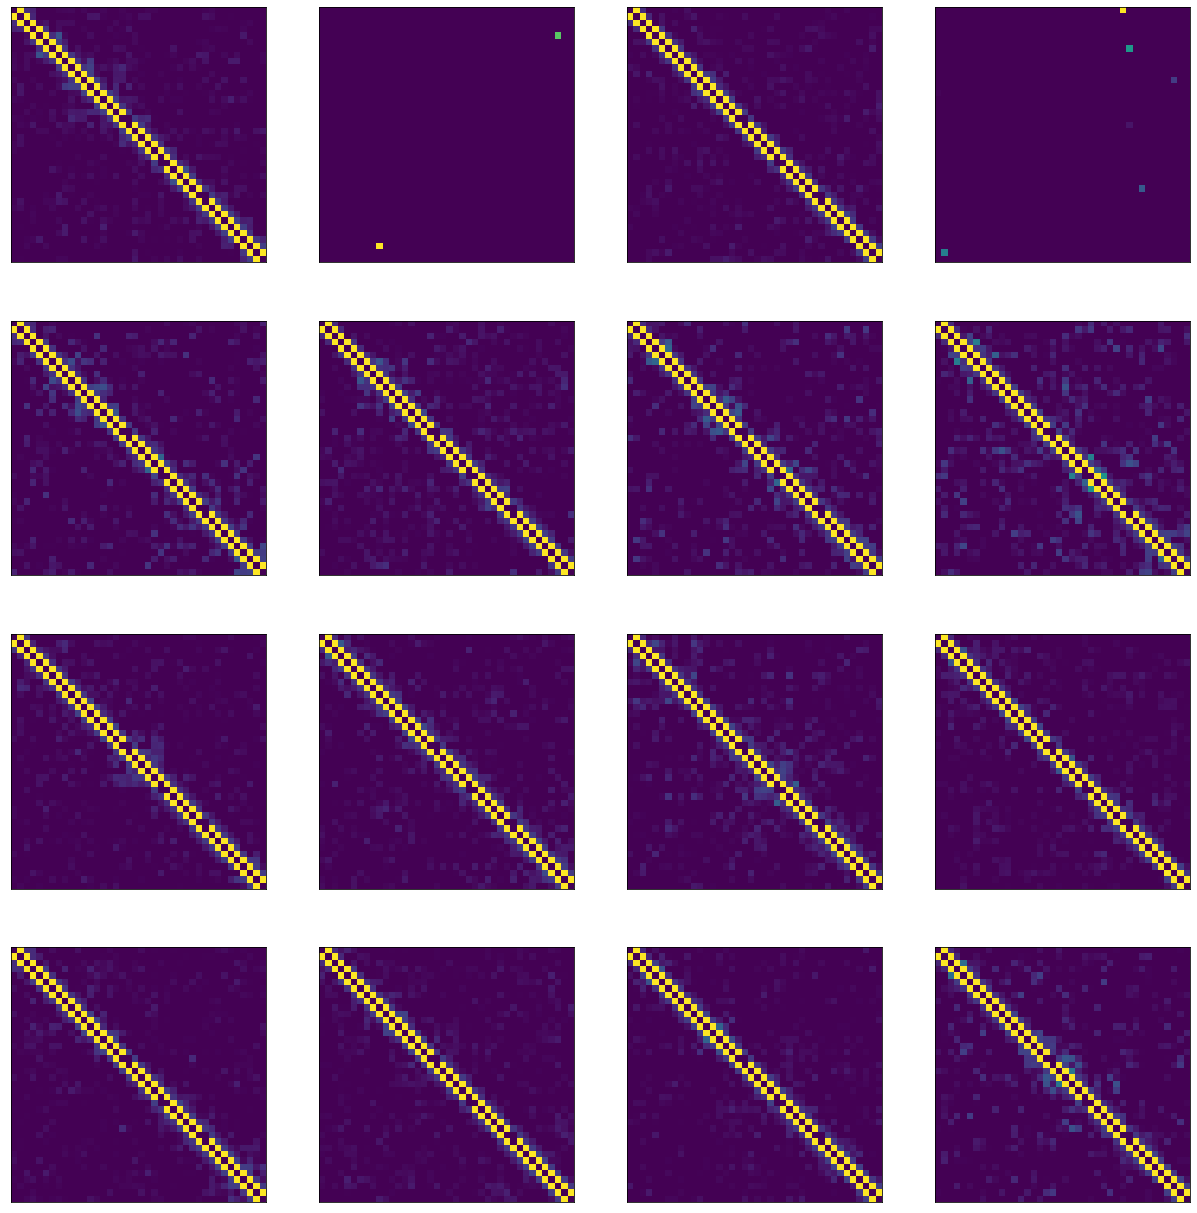

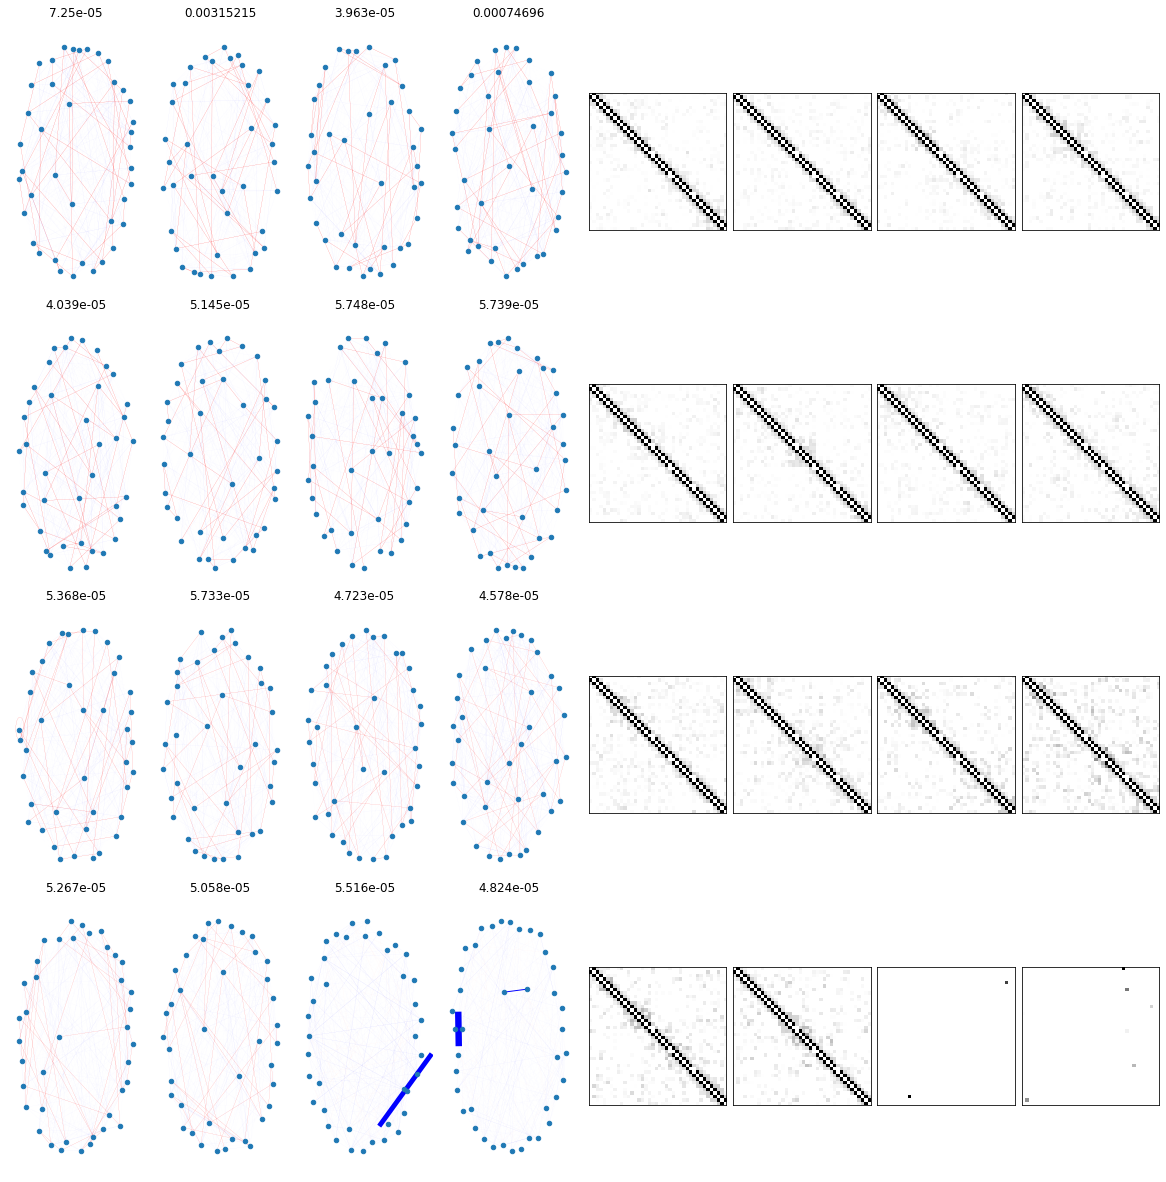

In [46]:
display_dictionary(W = W, figsize = [20,20])

display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 150, 
                       fig_size = [20,20], 
                       show_importance = True)